# Setting up Paths

In [6]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
#path to compasrepo which contains ther popsynth folder
# pathRepo = '/Users/floorbroekgaarden/Programs/COMPAS/popsynth/Papers/BroekgaardenEtAl/black_hole-neutron_star/Scripts'



pathPostProcessing = '/Users/floorbroekgaarden/Projects/BHNS_project/Scripts'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# jt -l
# jt -t oceans16 -f roboto -fs 12 -cellw 100%

# Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
import sys
import copy
#Quick fudge to make import from ../Scripts work
import sys
sys.path.append('/Users/floorbroekgaarden/Projects/BHNS_project/Scripts')
# sys.path.append(pathPostProcessing+'/2_CosmicIntegration')

# Custom Imports from COMPASrepo

In [8]:
import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data
# import ClassEvents            as CE
# import ClassBayes             as CB
import coencodeVarious        as CV
from PostProcessingScripts import * 


['A.0.0.0', 'A.1.1.1', 'A.2.1.1', 'A.3.1.1', 'A.1.1.2', 'A.2.1.2', 'A.3.1.2', 'A.1.1.3', 'A.2.1.3', 'A.3.1.3', 'A.1.2.1', 'A.2.2.1', 'A.3.2.1', 'A.1.2.2', 'A.2.2.2', 'A.3.2.2', 'A.1.2.3', 'A.2.2.3', 'A.3.2.3', 'A.1.3.1', 'A.2.3.1', 'A.3.3.1', 'A.1.3.2', 'A.2.3.2', 'A.3.3.2', 'A.1.3.3', 'A.2.3.3', 'A.3.3.3']


# The cosmic integrator class

In [72]:
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 1000
Data = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP', COMPASbinaryFraction=0.6)

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data.COMPAS.mass1)

KeyboardInterrupt: 

# The plot -- [COEN] SCROLL DOWN!!

In [5]:
#The distribution of DCOs as a function of redshift

method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


cm       = plt.get_cmap('viridis')
nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]




rates    = []
totals   = []
for nrL, L in enumerate(labels):
    Data.MSSFR.Zprescription         = method[nrL]
    Data.MSSFR.SFRprescription       = SFRs[nrL]
    Data.MSSFR.logNormalPrescription = logNormal[nrL]
    Data.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data.MSSFR.ZMprescription        = MZs[nrL]
    Data.cosmologicalIntegration()
        
    
    Row        =np.sum(Data.PerSystemPerRedshift_ratesObserved, axis=0)
    rates.append(Row)
    totals.extend([np.sum(Row)])
    print(L, np.sum(Row))

('Preferred model', 895.1625058416562)
('Barrett et al. (2018) MSSFR', 5313.74474036679)
('Furlong et al. (2015) Single', 4641.210502253822)
('Ma et al. (2015)', 1699.406541536214)


In [ ]:
##### For each observation (column) we draw a chirpmass with probability gaussian

events     = CE.Observations() 
names, values, lowerErrors, upperErrors, survey =\
events.giveParameterAndError(parameter='Mchirp', types=['BBH'])  


draws = 5000
arraydraws = np.zeros(shape=(draws, len(names)))


Mtot       = Data.COMPAS.mChirp
bins       = np.linspace(0,60,250)
centerx     = (bins[1:]+bins[:-1])/2.
dMtot      = np.diff(bins)
gaussians  = []

Bayes      = CB.BayesianLikelyhoodSingleObservation(datapoints = Data.COMPAS.mChirp)
for nre, event in enumerate(names):
    Bayes.setObservation(observation=values[nre], lowerError=lowerErrors[nre], \
                         upperError=upperErrors[nre], confidence=0.9)
    Bayes.calculatePDFposterior()
    pdf, bins = np.histogram(Bayes._x, bins=bins, weights=Bayes._PDFobservation)
    gaussians.append(pdf)
    
    sigma   = Bayes._sigmaSymmetric
    mu      = Bayes._symmetricMu
    s = np.random.normal(mu, sigma, draws)
    arraydraws[:,nre] = s

In [ ]:
###### Turn each PDF into CDF per model

chirpMasses     = Data.COMPAS.mChirp
indexSortMasses = np.argsort(chirpMasses)
sortedMasses    = chirpMasses[indexSortMasses]
CDFs            = []
for nrM, model in enumerate(labels):
    sortedRate  = rates[nrM][indexSortMasses]
    CDFs.append(np.cumsum(sortedRate)/float(np.sum(sortedRate)))
fig, axes = plt.subplots(1,1)
for cdf in CDFs:
    axes.plot(sortedMasses, cdf)
plt.show()

In [ ]:
def return10Masses(cdf, masses):
    #draw number between 0-1
    nrdraws = 10
    d = np.random.uniform(low=0.0, high=1.0, size=nrdraws)
    #find nearest value cdf
    indices = np.zeros(nrdraws, dtype=int)
    for nrd, draw in enumerate(d):
        difference   = np.abs(cdf-draw)
        minimum      = np.min(difference)
        indices[nrd] = int(np.where(difference == minimum)[0][0])
    indices = np.array(indices)
    return np.sort(masses[indices])

y10draws = np.cumsum(np.ones(10)/np.sum(np.ones(10)))
x10draws = []
counter  = 0
while counter < draws:
    masses = return10Masses(CDFs[0], sortedMasses)
    x10draws.append(masses)
    counter+=1
    
print(len(x10draws))

In [ ]:
fig        = plt.subplots(1,1,figsize=(9,14))
ax0        = plt.subplot2grid((6,3),(0,0), colspan=3, rowspan=3)
# ax1        = plt.subplot2grid((6,3),(3,0), colspan=3, rowspan=3)

# ax12 = ax1.twinx() #right side bottom panel for cumulative

############
#  Top panel with MSSFR
############
Mtot       = Data.COMPAS.mChirp
bins       = np.linspace(1,7.5,100)
center     = (bins[1:]+bins[:-1])/2.
dMtot      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(Mtot, bins=bins, weights = rate)
    rate       = np.divide(rate, dMtot)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
nameY = r'$\rm dP / dM_{chirp} \ [M_{\odot}^{-1}]  $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
ax0.set_ylim(bottom=-0.002, top=0.071)


##########
#
#########


    
# ax12.set_xlim(ax0.get_xlim())
# ax1.set_xlim(ax0.get_xlim())
# ax1.set_ylim(top=1.01)
# y = ax1.get_yticks()
# ax1.set_yticks(y[:-2])
# ax12.set_ylim(top=0.8)
# ax12.get_yaxis().set_visible(False)
# nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
# nameY = r'$\rm CDF $'
# ax1 = CV.layoutAxes(ax1, nameX=nameX, nameY=nameY)
# ax12 = CV.layoutAxes(ax12, nameX='', nameY='', second=True)
plt.tight_layout()
# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./MassDistributionAtRedshiftObs.png', dpi=300, transparent=False)
plt.show()
# plt.close()

# 1. 

In [7]:
# #The distribution of DCOs as a function of redshift

# method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
# SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
# logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
# GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
# MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

# linestyles = ['-'                        , '--'                         , ':'                           , '-.']
# labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


# cm       = plt.get_cmap('viridis')
# nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
#                     # dont want the brigthest colour hence I add a dummy value.
#                     #Should be consistent with figure of metallicity PDFs
# mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

# colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]




In [6]:
# #path to the data
# pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
# modelname = 'Fiducial'
# #Will only look at BBHs so might as well set everything
# minz = 0.
# maxz = 1.
# resz = 50
# Data_model1 = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
#        minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

# #I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
# #Doesnt matter to much (between WMAP and 
# #this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

# print(Data_model1.COMPAS.mass1)
# print(len(Data_model1.COMPAS.mass1))

In [9]:
#     def printSFRoptions(self):

#         print("""
#         Default instance:
#         self.SFRprescription       = None 

#         Current Options  = Madau et al. (2014)
#                            Madau et al. (2017)
#                            Strolger et al. (2004)
#                            Neijssel et al. (2019)

#         """)

#     def printZMoptions(self):


#         print("""
#         If you use MZ and GSMF relations
#         i.e. self.Zprescription    = 'MZ_GSMF'

#         Default instance
#         self.ZMprescription        = None
#         Current Options = Ma et al. (2015),
#                       Langer et al. (2006)
#                       Langer et al. +offset (2006)
#         """)



#     def printGSMFoptions(self):


#         print("""
#         If you use MZ and GSMF relations
#         i.e. self.Zprescription    = 'MZ_GSMF'

#         Default instance
#         self.GSMFprescription      = None
#         Current Options = Panter et al. (2004) Single, 
#                           Furlong et al. (2015) Single,
#                           Furlong et al. (2015) Double
#         """







# rates_model1    = []
# totals_model1   = []
# for nrL, L in enumerate(labels):
#     Data_model1.MSSFR.Zprescription         = method[nrL]
#     Data_model1.MSSFR.SFRprescription       = SFRs[nrL]
#     Data_model1.MSSFR.logNormalPrescription = logNormal[nrL]
#     Data_model1.MSSFR.GSMFprescription      = GSMFs[nrL]
#     Data_model1.MSSFR.ZMprescription        = MZs[nrL]
#     Data_model1.cosmologicalIntegration()
#     weightSTROOPWAFEL = Data_model1.COMPAS.weight # //floor weight
#     Row        =  np.sum(Data_model1.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
# #     Row        =np.sum(Data_model1.PerSystemPerRedshift_ratesObserved, axis=0)
#     rates_model1.append(Row)
#     totals_model1.extend([np.sum(Row)])
#     print(L, np.sum(Row))

('Preferred model', 6.428338137313037)
('Barrett et al. (2018) MSSFR', 36.52149582603046)
('Furlong et al. (2015) Single', 34.073040697690224)
('Ma et al. (2015)', 11.186948828345791)


# Fiducial model 

In [5]:


#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
modelname = 'Fiducial'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
Data_model1 = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model1.COMPAS.mass1)
print(len(Data_model1.COMPAS.mass1))


#######


rates_model1    = []
totals_model1   = []


method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']



rates_model1    = []
totals_model1   = []
labelslist = []

GSMFs = ['Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Furlong et al. (2015) Double']
MZs   = [ 'Langer et al. (2006)'      , 'Langer et al. +offset (2006)', 'Ma et al. (2015)']
SFRs  = ['Madau et al. (2014)'         ,'Strolger et al. (2004)',     'Madau et al. (2017)']


# Neijssel:
         
Data_model1.MSSFR.Zprescription         = 'logNormal' 
Data_model1.MSSFR.SFRprescription       = 'Neijssel et al. (2019)'
Data_model1.MSSFR.logNormalPrescription = 'Neijssel Phenomenological'
Data_model1.MSSFR.GSMFprescription      = None
Data_model1.MSSFR.ZMprescription        = None
Data_model1.cosmologicalIntegration()
weightSTROOPWAFEL = Data_model1.COMPAS.weight # //floor weight
Row        =  np.sum(Data_model1.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model1.PerSystemPerRedshift_ratesObserved, axis=0)
rates_model1.append(Row)
totals_model1.extend([np.sum(Row)])
labelslist.append('Neijssel 2019')
for ind_GSMF, GSMF in enumerate(GSMFs):
         for ind_MZ, MZ in enumerate(MZs):
             for ind_SFR, SFR in enumerate(SFRs):
                 
                Data_model1.MSSFR.Zprescription         = 'MZ_GSMF'
                Data_model1.MSSFR.SFRprescription       = SFR
#                 Data_model1.MSSFR.logNormalPrescription = logNormal[nrL]
                Data_model1.MSSFR.GSMFprescription      = GSMF
                Data_model1.MSSFR.ZMprescription        = MZ
                Data_model1.cosmologicalIntegration()
                weightSTROOPWAFEL = Data_model1.COMPAS.weight # //floor weight
                Row        =  np.sum(Data_model1.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
            #     Row        =np.sum(Data_model1.PerSystemPerRedshift_ratesObserved, axis=0)
                rates_model1.append(Row)
                totals_model1.extend([np.sum(Row)])
         
                labelslist.append(SFR + r'$\_+\_' + GSMF + r'$\_+\_' + MZ )
                
         

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[2.06203 9.0769  2.98903 ... 4.78319 4.4085  4.66631]
1366530


In [66]:
print(np.shape(rates_model1[0]))

(1366530,)


In [8]:

# GSMFs = ['Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Furlong et al. (2015) Double']
# MZs   = [ 'Langer et al. (2006)'      , 'Langer et al. +offset (2006)', 'Ma et al. (2015)']
# SFRs  = ['Madau et al. (2014)'         ,'Strolger et al. (2004)',     'Madau et al. (2017)']



# modelnameslist = ['m.0.0.0', ]

In [6]:


GSMFs = ['Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Furlong et al. (2015) Double']
MZs   = [ 'Langer et al. (2006)'      , 'Langer et al. +offset (2006)', 'Ma et al. (2015)']
SFRs  = ['Madau et al. (2014)'         ,'Strolger et al. (2004)',     'Madau et al. (2017)']




modelnameslistA = []

mm = 'A' # Pop synth model name
modelnameslistA.append(mm+'.0.0.0') # add phenomenological 

for ind_GSMF, GSMF in enumerate(GSMFs):
    ind_y = ind_GSMF + 1
    for ind_MZ, MZ in enumerate(MZs):
        ind_z = ind_MZ +1
        for ind_SFR, SFR in enumerate(SFRs):
            ind_x = ind_SFR+1
            
            
            
            
        

            modelnameslistA.append(mm+'.%s.%s.%s'%(ind_x, ind_y, ind_z))
print(modelnameslistA)

['A.0.0.0', 'A.1.1.1', 'A.2.1.1', 'A.3.1.1', 'A.1.1.2', 'A.2.1.2', 'A.3.1.2', 'A.1.1.3', 'A.2.1.3', 'A.3.1.3', 'A.1.2.1', 'A.2.2.1', 'A.3.2.1', 'A.1.2.2', 'A.2.2.2', 'A.3.2.2', 'A.1.2.3', 'A.2.2.3', 'A.3.2.3', 'A.1.3.1', 'A.2.3.1', 'A.3.3.1', 'A.1.3.2', 'A.2.3.2', 'A.3.3.2', 'A.1.3.3', 'A.2.3.3', 'A.3.3.3']


In [43]:
# modelnameslist
# modelnameslistcolours=[]
# modelnameslistcolours.append('red') # = np.zeros_like(modelnameslist)
# # modelnameslistcolours[0] ='red'

# for ind_GSMF, GSMF in enumerate(GSMFs):
#     ind_y = ind_GSMF + 1
#     for ind_MZ, MZ in enumerate(MZs):
#         ind_z = ind_MZ +1
#         for ind_SFR, SFR in enumerate(SFRs):
#             ind_x = ind_SFR+1
            
#             if (ind_y==3) :
#                 modelnameslistcolours.append('blue')
#             else:
#                 modelnameslistcolours.append('gray')


In [7]:
def plotdesigndistributionMSSFR(axe, xvar, weights, bandwidth, xvarrange, labellist, xlabel, ylabel, xlim, ylim, indplot):
    """ plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """


    axes = [axe]
    


    res_kde =100 # resolution kde, just the nr of interpolation points (so this is not the bandwith). 
    if xvarrange:
        xx_boot = np.linspace(xvarrange[0], xvarrange[1], res_kde)
    else:
        xx_boot = np.linspace(min(xvar)*0.8,max(xvar)*1.2, res_kde)
    
    
#     model_1list = [1,2,3,10,11,12,19,20,21] 
#     colorgreen = sns.light_palette("green",len(model_1list)) 
#     colorblue = sns.light_palette("blue",(len(labelslist)-len(model_1list)-1)) 
    ind_g, ind_b = 0,0
    for ind_MSSFR, MSSFR_rate in enumerate(weights):
        
        if ind_MSSFR%10==1:
            print('at ind =', ind_MSSFR)
        
        
        COLOR=modelcolors[ind_MSSFR]
        zorder=1
#         if ind_MSSFR in model_1list:
#             COLOR=colorgreen[ind_g]
#             ind_g+=1
#         elif ind_MSSFR==0:
#             COLOR='darkorange'
#             zorder = 100
        
#         else:
#             COLOR=colorblue[ind_b]
#             ind_b+=1

        # highlight used models
        if ind_MSSFR==0:
            COLOR='crimson'
            zorder = 100
            label=labellist[ind_MSSFR]
        elif ind_MSSFR in [1]:
            COLOR='teal'
            zorder=10
            label=labellist[ind_MSSFR]
        elif ind_MSSFR in [2]:
            COLOR='c'
            zorder=10
            label=labellist[ind_MSSFR]
        elif ind_MSSFR in [7]:
            zorder=10
            COLOR='gold'
            label=labellist[ind_MSSFR]
        else:
            COLOR='lightgray'
            zorder=2
            label=None





#         axe.hist(xvar, bins=xx_boot, weights=MSSFR_rate,\
#                  color=COLOR, label=label, \
#                  linewidth=4, histtype='step' , density=True, zorder=zorder)
        KDE = gaussian_kde(xvar, weights=MSSFR_rate, bw_method = bandwidth)
        y_boot = KDE(xx_boot)
        
        
        
        axe.plot(xx_boot,  y_boot, c=COLOR, label=label,\
                 linewidth=5, zorder=zorder)
    
    ###########

        
    if indplot=='log':
#         axe.set_xscale('log')
        axe.set_yscale('log')
        
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])
        
    axe == CV.layoutAxes(axe, nameX=xlabel, nameY=ylabel)

    
    if indplot==0: 
        handles, labels = axe.get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    axe.grid(True)
    
    
    return handles, labels
    

('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)


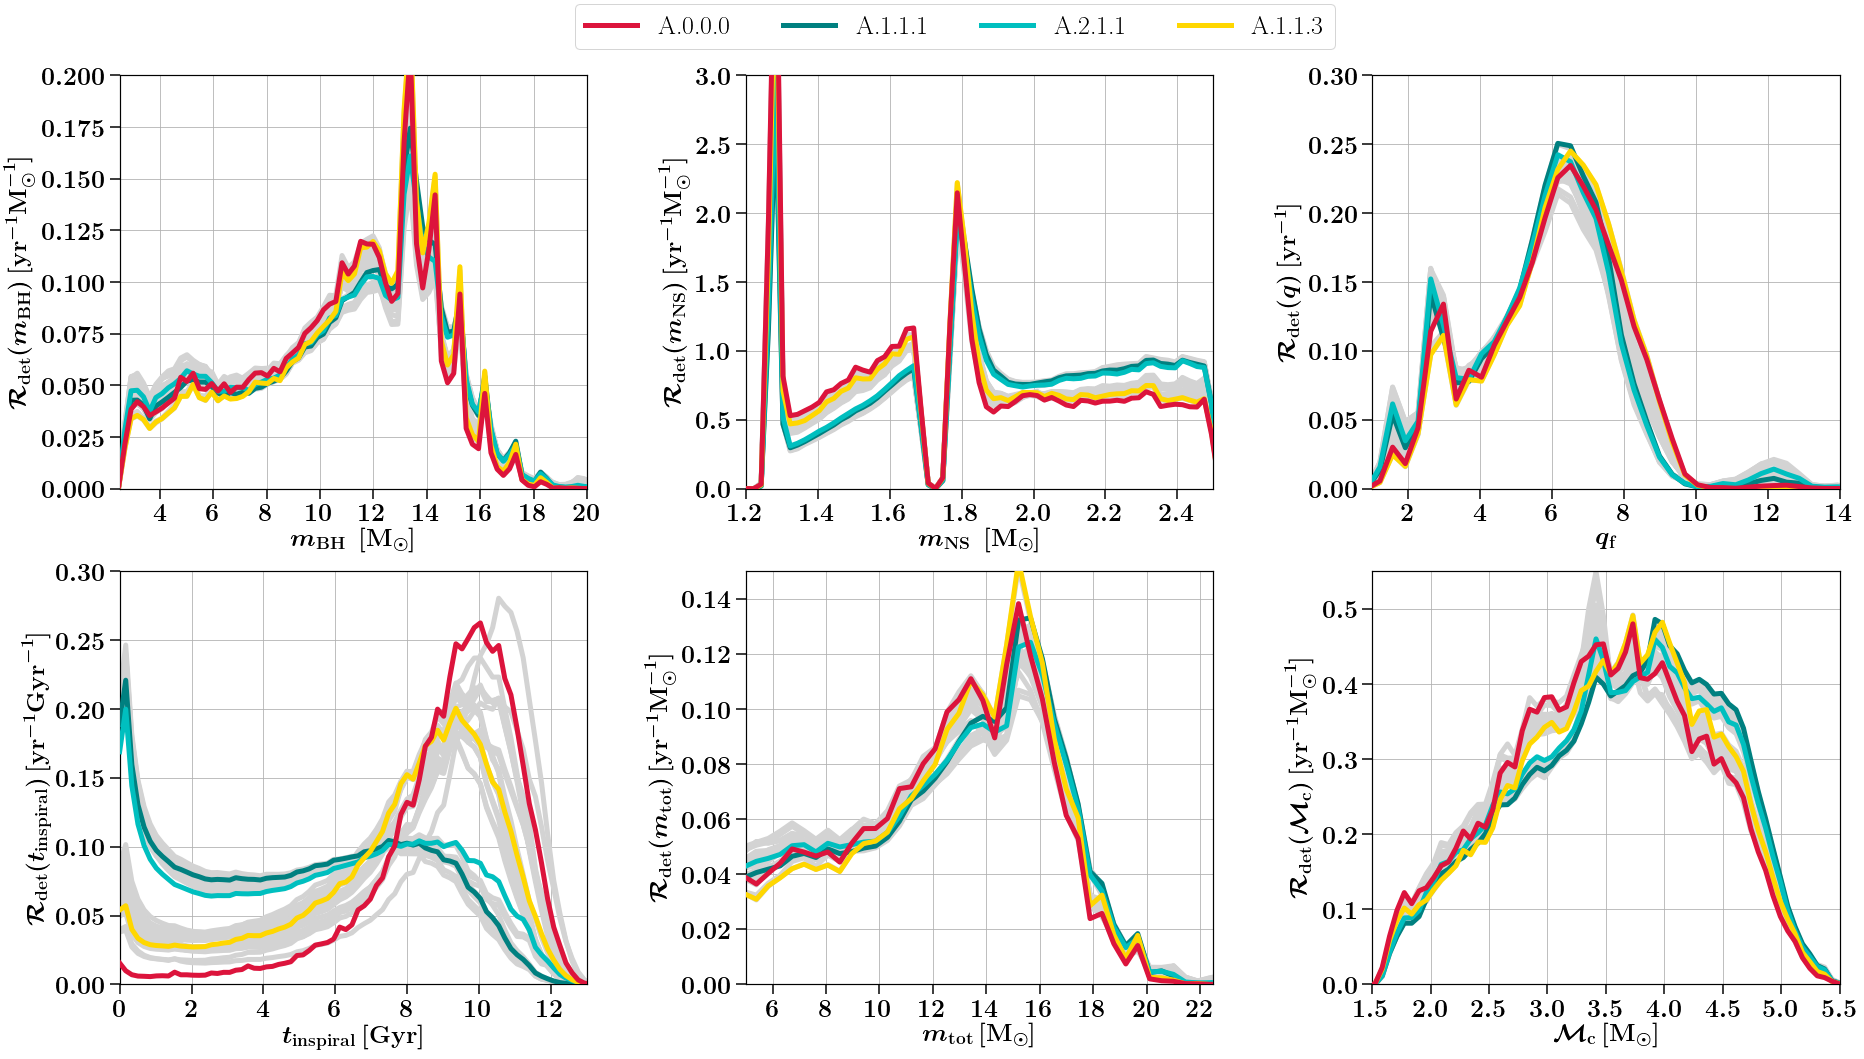

In [9]:
modelcolors = sns.color_palette("husl", len(labelslist)) 
# modelcolors=modelnameslistcolours
# BNS 
# dictChannelsList = ['classic',  'double-core CE', 'other']    
    
linewidth=3.5
ALPHA=0

f, ax= plt.subplots(ncols=3,nrows=2,figsize=(26,14), 
                  gridspec_kw={"width_ratios":[1.5, 1.5,1.5], "height_ratios":[2,2]})



#general
Nbins= .03 #.05#50 #.1 #50




####### BH MASS 

Data = Data_model1
M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

# rate_disrupted = np.zeros(4)
# # CHECK EJECTA MASS? 
# ii=0
# allweight = np.sum(Data.PerSystemPerRedshift_ratesObserved*Data.COMPAS.weight, axis=0)
# for ind_chi, chi in enumerate([0.0, 0.5]):
#     BH_chi   = chi * np.ones_like(MNS)
#     for ind_Rns, NSradii in enumerate([11.5,13.0]):
#         Rns = NSradii
#         NS_radii = Rns * np.ones_like(MNS)

#         Mej = calculateEjectedMassMerger(m_ns=MNS, r_ns=NS_radii, m_bh=MBH, Xeff=BH_chi)

#         maskEjecta = (Mej > 0)


#         combinedweight = np.sum(Data.PerSystemPerRedshift_ratesObserved*Data.COMPAS.weight, axis=0)[maskEjecta]
        
#         rate_disrupted[ii]+= np.sum(combinedweight) / np.sum(allweight)
#         ii+=1




modelnameslist = modelnameslistA

xvar = MBH
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'


handles, labels=plotdesigndistributionMSSFR(axe=ax[0,0], xvar=xvar, weights=rates_model1,\
                                       bandwidth=Nbins, xvarrange=[2,25], labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,20], ylim=[0,0.2], indplot=0) 


####### NS MASS 
xvar = MNS
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{NS}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{NS}}$   $ \,  [\rm{M}_{\odot}]$ '

# _,_=plotdesigndistribution(axe=ax[0,1], xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
#                               xlim=[1.2,2.5], ylim=[0,20], indplot=1) 


_,_=plotdesigndistributionMSSFR(axe=ax[0,1], xvar=xvar, weights=rates_model1,\
                                       bandwidth=Nbins, xvarrange=[1,3], labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1.2,2.5], ylim=[0,3], indplot=1) 


####### mass ratio
xvar = MBH/MNS
nameY = r'$\mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
nameX = r'$q_{\rm{f}}$'

_,_=plotdesigndistributionMSSFR(axe=ax[0,2], xvar=xvar,weights=rates_model1,\
                           bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,14], ylim=[0,0.3], indplot=2) 

# # ######## INSPIRAL TIME
# xvar = Data.COMPAS.tc / 1000
# nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
# nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

# _,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1,\
#                                 bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
#                               xlim=[0,13.7], ylim=[0,.4], indplot=3) 



# # ######## INSPIRAL TIME
xvar = Data.COMPAS.tc / 1000
nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

_,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1,\
                                bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[0,13], ylim=[0,.3], indplot=3) 



# xvar = np.log10(Data.COMPAS.tc / 1000)
# nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
# nameX = r'$\log_{10} t_{\rm{inspiral}} \, [\rm{Gyr}]$'

# _,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1,\
#                                 bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
#                               xlim=[-4,3], ylim=[0,.4], indplot=3) 





# ####### mass total
xvar = MBH+MNS
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistributionMSSFR(axe=ax[1,1], xvar=xvar,weights=rates_model1,\
                           bandwidth=Nbins, xvarrange=None, labellist=modelnameslist,xlabel=nameX, ylabel=nameY, \
                              xlim=[5,22.5], ylim=[0,0.15], indplot=4) 


# ####### mass chirp
xvar = chirpmass(MBH, MNS)

nameY = r'$\mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'
# nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'


_,_=plotdesigndistributionMSSFR(axe=ax[1,2], xvar=xvar,weights=rates_model1,\
                           bandwidth=Nbins, xvarrange=None, labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1.5,5.5], ylim=[0,0.55], indplot=5) 

# # ###########


# LEGEND
lgd = f.legend(handles, labels, fontsize=fs+2, ncol=4,\
         bbox_to_anchor=(.72, 1.06),  markerscale=5., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
# plt.savefig('./ObservedDistributionsFiducial_MSSFR_gaussianKDE_highlight.png', dpi=100, transparent=False,\
#            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
# plt.close()



# (axe, xvar, bandwidth,  xlabel, ylabel, xlim, ylim, indplot)




In [64]:

print(rates_model1[0])


[0.         0.         0.         ... 0.00056282 0.00061177 0.0035548 ]


In [11]:
import pandas as pd

In [11]:


GSMFs = ['Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Furlong et al. (2015) Double']
MZs   = [ 'Langer et al. (2006)'      , 'Langer et al. +offset (2006)', 'Ma et al. (2015)']
SFRs  = ['Madau et al. (2014)'         ,'Strolger et al. (2004)',     'Madau et al. (2017)']




MSSFRnameslist = []

mm = 'A' # Pop synth model name
MSSFRnameslist.append('.0.0.0') # add phenomenological 

for ind_GSMF, GSMF in enumerate(GSMFs):
    ind_y = ind_GSMF + 1
    for ind_MZ, MZ in enumerate(MZs):
        ind_z = ind_MZ +1
        for ind_SFR, SFR in enumerate(SFRs):
            ind_x = ind_SFR+1
            
            
            
            
        

            MSSFRnameslist.append('.%s.%s.%s'%(ind_x, ind_y, ind_z))
print(MSSFRnameslist)

['.0.0.0', '.1.1.1', '.2.1.1', '.3.1.1', '.1.1.2', '.2.1.2', '.3.1.2', '.1.1.3', '.2.1.3', '.3.1.3', '.1.2.1', '.2.2.1', '.3.2.1', '.1.2.2', '.2.2.2', '.3.2.2', '.1.2.3', '.2.2.3', '.3.2.3', '.1.3.1', '.2.3.1', '.3.3.1', '.1.3.2', '.2.3.2', '.3.3.2', '.1.3.3', '.2.3.3', '.3.3.3']


In [19]:
MSSFRnameslist = []


MSSFRnameslist.append('.0.0.0') # add phenomenological 

for ind_GSMF, GSMF in enumerate(GSMFs):
    ind_y = ind_GSMF + 1
    for ind_MZ, MZ in enumerate(MZs):
        ind_z = ind_MZ +1
        for ind_SFR, SFR in enumerate(SFRs):
            ind_x = ind_SFR+1
            
            
            
            
        

            MSSFRnameslist.append('.%s.%s.%s'%(ind_x, ind_y, ind_z))

In [21]:
import string
alphabet = list(string.ascii_uppercase)


BPSnameslist = alphabet[:10]
print(BPSnameslist)


NAMES = []

for ind_l, L in enumerate(alphabet[:10]):
    str_z0 = str(L + ' intrinsic (z=0) [Gpc^{-3} yr^{-1}]')
    str_obs = str(L + ' observed (design LVK) [yr^{-1}]')
    NAMES.append(str_z0)
    NAMES.append(str_obs)
    
    
print(NAMES)


UNITS = []

for ind_l, L in enumerate(alphabet[:10]):
    str_z0 = str('[Gpc^{-3} yr^{-1}]')
    str_obs = str('[yr^{-1}]')
    UNITS.append(str_z0)
    UNITS.append(str_obs)






['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
['A intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'A observed (design LVK) [yr^{-1}]', 'B intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'B observed (design LVK) [yr^{-1}]', 'C intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'C observed (design LVK) [yr^{-1}]', 'D intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'D observed (design LVK) [yr^{-1}]', 'E intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'E observed (design LVK) [yr^{-1}]', 'F intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'F observed (design LVK) [yr^{-1}]', 'G intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'G observed (design LVK) [yr^{-1}]', 'H intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'H observed (design LVK) [yr^{-1}]', 'I intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'I observed (design LVK) [yr^{-1}]', 'J intrinsic (z=0) [Gpc^{-3} yr^{-1}]', 'J observed (design LVK) [yr^{-1}]']


In [9]:
# print(np.shape(totals_model1))
# print(totals_model1)
import numpy as np
datas = []
# datas.append(totals_model1)

for i in range(len(NAMES)):
    datas.append(np.zeros_like(MSSFRnameslist))

In [26]:
df = pd.DataFrame(data=datas, index=NAMES).T
df.index =   MSSFRnameslist
df.index.names = ['.x.y.z']
df.columns.names = ['m']
# df.columns = pd.MultiIndex.from_tuples(zip(UNITS, df.columns))

print(df)

m      A intrinsic (z=0) [Gpc^{-3} yr^{-1}] A observed (design LVK) [yr^{-1}]  \
.x.y.z                                                                          
.0.0.0                                                                          
.1.1.1                                                                          
.2.1.1                                                                          
.3.1.1                                                                          
.1.1.2                                                                          
.2.1.2                                                                          
.3.1.2                                                                          
.1.1.3                                                                          
.2.1.3                                                                          
.3.1.3                                                                          
.1.2.1                      

In [27]:
df.to_csv('MSSFR_rates.csv')


In [28]:
df = pd.read_csv('MSSFR_rates.csv', index_col=0)


print(df['C intrinsic (z=0) [Gpc^{-3} yr^{-1}]'])

.x.y.z
.0.0.0   NaN
.1.1.1   NaN
.2.1.1   NaN
.3.1.1   NaN
.1.1.2   NaN
.2.1.2   NaN
.3.1.2   NaN
.1.1.3   NaN
.2.1.3   NaN
.3.1.3   NaN
.1.2.1   NaN
.2.2.1   NaN
.3.2.1   NaN
.1.2.2   NaN
.2.2.2   NaN
.3.2.2   NaN
.1.2.3   NaN
.2.2.3   NaN
.3.2.3   NaN
.1.3.1   NaN
.2.3.1   NaN
.3.3.1   NaN
.1.3.2   NaN
.2.3.2   NaN
.3.3.2   NaN
.1.3.3   NaN
.2.3.3   NaN
.3.3.3   NaN
Name: C intrinsic (z=0) [Gpc^{-3} yr^{-1}], dtype: float64


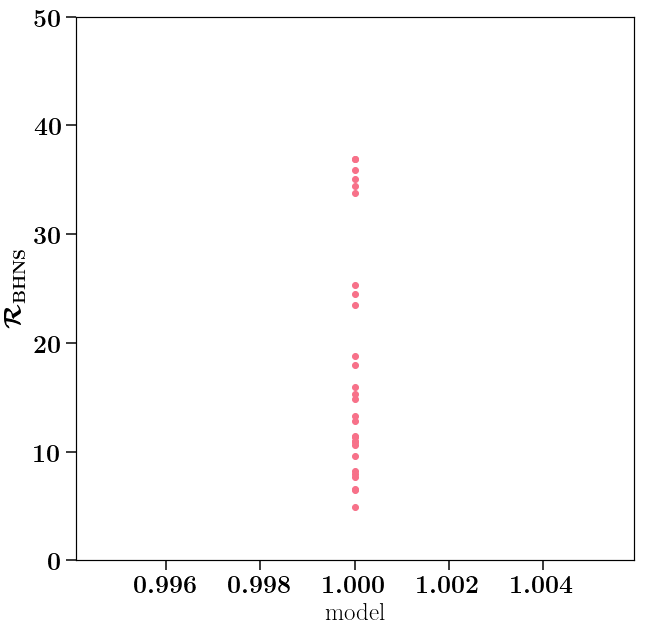

In [62]:
rates_A = df['A']
xx=np.ones_like(rates_A)


f, axe= plt.subplots(ncols=1,nrows=1,figsize=(10,10), 
                  gridspec_kw={"width_ratios":[ 1.5], "height_ratios":[2]})

axe.scatter(xx, rates_A, c=modelcolors[0])
xlabel  ='model'
ylabel =r'$\mathcal{R}_{\rm{BHNS}} $'
axe.set_ylim(0,50)
axe == CV.layoutAxes(axe, nameX=xlabel, nameY=ylabel)
plt.show()

In [ ]:
# Fiducial model MSSFR VIDEO with FORMATION CHANNELS

In [7]:
def plotdesigndistribution(axe, xvar, weights, bandwidth, xvarrange, xlabel, ylabel, xlim, ylim, indplot, ind_MSSFR):
    """ plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """
    groups  = dictChannelsBBHList  

    axes = [axe]
    
    weightSTROOPWAFEL = Data.COMPAS.weight
    

    res_kde =1000 # resolution kde, just the nr of interpolation points (so this is not the bandwith). 
    if xvarrange:
        binsM = np.linspace(xvarrange[0], xvarrange[1], res_kde)
    else:
        binsM =np.linspace(min(xvar)*0.9, 1.1*max(xvar), res_kde)
    dM    = np.diff(binsM)
    M     = (binsM[1:]+binsM[:-1])/2.

    

#     binpoints_x = np.zeros(2*(len(binsM)-1))
#     binpoints_y = np.zeros(2*(len(binsM)-1))
#     binpoints_x[::2] = binsM[:-1]
#     binpoints_x[1::2]= binsM[1:]    

    
    # print len(chirp)

    totalweight = 0

#     fig, axes = plt.subplots(1,1,figsize=(16,8))
    xx_boot = np.linspace(min(xvar)*0.8,max(xvar)*1.2, 100)
    yLow        = np.zeros(len(xx_boot))

    
    for nrG, group in enumerate(groups):
        # only if the channel group is present do plotting:
        if len(xvar[channelSystems == nrG]):
            m       = xvar[channelSystems == nrG]
            w       = weights[channelSystems == nrG]
            percentage = np.round((np.sum(w)/float(np.sum(weights)))*100,2)
            y, _    = np.histogram(m, bins=binsM, weights=w)
            y       = np.divide(y, dM)

            # remake histogram


            totalweight += np.sum(w)
            totalweight_nrG = np.sum(w)
            ##

            KDE = gaussian_kde(m, weights=w, bw_method = bandwidth)
            y_boot = KDE(xx_boot)


            ##
            if indplot==0:
                LABEL = dictChannelsBHNSListBolt[nrG]+' '+str(percentage)+'\%'
                print(LABEL)
            else:
                LABEL = None


            axe.fill_between(xx_boot, yLow, yLow+((y_boot*totalweight_nrG)/(np.sum(weights))), facecolor=colorlist[nrG], alpha=0.8, label=LABEL)#,\
    #                           label=)
            yLow   +=(y_boot*totalweight_nrG)/(np.sum(weights))
    
#     axe.fill_between(xx_boot, yLow, yLow+(y_boot*totalweight_nrG), facecolor=colorlist[nrG], alpha=0.8, label=LABEL)#,\
# #                           label=)
    # plot thick black line on top of overall distribution    
    axe.plot(xx_boot,  (yLow), color='k', linewidth=5)
    
    ### PLOT CDF on right axes ###
    ax2y = axe.twinx()

    # label / tick settings
    cdfcolor = 'red'
    ylabel2 = 'CDF'

    ax2y.set_ylim(0,1)
    ax2y.tick_params(labelsize=fs, colors=cdfcolor)
    ax2y.set_ylabel(ylabel2, fontsize=fs, color=cdfcolor)       
    
    # plot cdf:
    ax2y.hist(xvar, normed=True, bins=len(xvar), cumulative=True, label=None,
         histtype='step', alpha=1, color=cdfcolor, linewidth=3, linestyle='-.', zorder=10, weights=weights)    
    
    ###########
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], max(yLow)*1.02) # ylim[1])

    axe == CV.layoutAxes(axe, nameX=xlabel, nameY=ylabel)

    
    if indplot==0: 
        handles, labels = axe.get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    axe.grid(True)
    axe.text(x=0.1,y=0.9, s='%s'%modelnameslist[ind_MSSFR], \
             fontsize=fs, horizontalalignment='left',\
             verticalalignment='center', transform=axe.transAxes)
    
    return handles, labels
    

(13774.99059456664, 'sum sorted counts')


NameError: name 'fc' is not defined

In [170]:

import ClassFormationChannels as FC 

fcmodel1 = FC.FormationChannels(path = pathCOMPASOutput,verbose=False)


fcmodel1.formationChannelsSeeds(seeds=Data_model1.COMPAS.seeds, withinHubbleTime=True, optimistic=False)





channelSystems  = np.ones(len(fcmodel1.rankArray)) * -1


# BHNS
for nrC, Channel in enumerate(dictChannelsBHNSList):
    subchannel = np.asarray(dictChannelsBHNS[Channel]) -1.
    for nrc, nr_subchannel in enumerate(subchannel):

    
        channelSystems[(fcmodel1.rankArray == nr_subchannel)] =nrC
    
# 4 = is "other channels"
channelSystems[(channelSystems ==-1.)] =4


print np.unique(channelSystems)

[0. 1. 2. 3. 4.]


In [115]:



for ind_MSSFR, MSSFR_rate in enumerate(rates_model1):
    print('--------------------------')
    print('now at MSSFR index =', ind_MSSFR)
    # BNS 
    # dictChannelsList = ['classic',  'double-core CE', 'other']    

    linewidth=3.5
    ALPHA=0


    f, ax= plt.subplots(ncols=2,nrows=3,figsize=(20,23), 
                      gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2,2]})


    #general
    Nbins= .03 #.05#50 #.1 #50




    ####### BH MASS 
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    rate_disrupted = np.zeros(4)
#     # CHECK EJECTA MASS? 
    ii=0

    for ind_chi, chi in enumerate([0.0, 0.5]):
        BH_chi   = chi * np.ones_like(MNS)
        for ind_Rns, NSradii in enumerate([11.5,13.0]):
            Rns = NSradii
            NS_radii = Rns * np.ones_like(MNS)

            Mej = calculateEjectedMassMerger(m_ns=MNS, r_ns=NS_radii, m_bh=MBH, Xeff=BH_chi)

            maskEjecta = (Mej > 0)




            rate_disrupted[ii]+= np.sum(MSSFR_rate[maskEjecta]) / np.sum(MSSFR_rate)
            ii+=1


#     #                 maskq5 = (MBH/MNS <=5.0)
    print()
    print('fraction disrupted =')
    print(rate_disrupted)
    print()




    xvar = MBH
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'

    handles, labels=plotdesigndistribution(axe=ax[0,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[2.5,20], ylim=[0,.22], indplot=0, ind_MSSFR=ind_MSSFR) 


    ####### NS MASS 
    xvar = MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{NS}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$m_{\rm{NS}}$   $ \,  [\rm{M}_{\odot}]$ '

    _,_=plotdesigndistribution(axe=ax[0,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[1.2,2.5], ylim=[0,5], indplot=1, ind_MSSFR=ind_MSSFR) 




    ####### mass ratio
    xvar = MBH/MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
    nameX = r'$q$'

    _,_=plotdesigndistribution(axe=ax[1,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,14], ylim=[0,.31], indplot=2, ind_MSSFR=ind_MSSFR) 

    ######## INSPIRAL TIME
    xvar = Data.COMPAS.tc / 1000
    nameY = r'$ \mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
    nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

    _,_=plotdesigndistribution(axe=ax[1,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[0,13.7], ylim=[0,0.37], indplot=3, ind_MSSFR=ind_MSSFR) 




    ####### mass total
    xvar = MBH+MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

    _,_=plotdesigndistribution(axe=ax[2,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[5,22.5], ylim=[0,0.22], indplot=4, ind_MSSFR=ind_MSSFR) 


    ####### mass chirp
    xvar = chirpmass(MBH, MNS)
    nameY = r'$ \mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'

    _,_=plotdesigndistribution(axe=ax[2,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[1.5,5.5], ylim=[0,0.55], indplot=5, ind_MSSFR=ind_MSSFR) 

    # ###########


    # LEGEND
    lgd = f.legend(handles, labels, fontsize=fs, ncol=3,\
             bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




    plt.tight_layout()
    plt.subplots_adjust(wspace=0.34, hspace=0.2)
    plt.savefig('./images_MSSFR_Fiducial_observedPredictions/ObservedDistributionsFiducial_m'+str(ind_MSSFR)+'.png', dpi=100, transparent=False,\
               bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.show()

    plt.close()



    # (axe, xvar, bandwidth,  xlabel, ylabel, xlim, ylim, indplot)




NameError: name 'rates_model1' is not defined

In [183]:
filenames = []
for ind_MSSFR, MSSFRrate in enumerate(rates_model1):
    filenames.append('./ObservedDistributionsFiducial_m'+ str(ind_MSSFR) +'.png')


import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('./images_MSSFR_Fiducial_observedPredictions/'+filename))
imageio.mimsave('./images_MSSFR_Fiducial_observedPredictions/MSSFRmovieFiducial.gif', images)

# BBH 

In [184]:


#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
modelname = 'Fiducial'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 100
TYPE ='BBH'
Data_model1_BBH = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model1_BBH.COMPAS.mass1)
print(len(Data_model1_BBH.COMPAS.mass1))


#######


rates_model1    = []
totals_model1   = []


method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']



rates_model1_BBH    = []
totals_model1_BBH   = []
# labelslist_BBH = []

GSMFs = ['Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Furlong et al. (2015) Double']
MZs   = [ 'Langer et al. (2006)'      , 'Langer et al. +offset (2006)', 'Ma et al. (2015)']
SFRs  = ['Madau et al. (2014)'         ,'Strolger et al. (2004)',     'Madau et al. (2017)']


# Neijssel:
         
Data_model1_BBH.MSSFR.Zprescription         = 'logNormal' 
Data_model1_BBH.MSSFR.SFRprescription       = 'Neijssel et al. (2019)'
Data_model1_BBH.MSSFR.logNormalPrescription = 'Neijssel Phenomenological'
Data_model1_BBH.MSSFR.GSMFprescription      = None
Data_model1_BBH.MSSFR.ZMprescription        = None
Data_model1_BBH.cosmologicalIntegration()
weightSTROOPWAFEL = Data_model1_BBH.COMPAS.weight # //floor weight
Row        =  np.sum(Data_model1_BBH.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model1_BBH.PerSystemPerRedshift_ratesObserved, axis=0)
rates_model1_BBH.append(Row)
totals_model1_BBH.extend([np.sum(Row)])
labelslist.append('Neijssel 2019')
for ind_GSMF, GSMF in enumerate(GSMFs):
         for ind_MZ, MZ in enumerate(MZs):
             for ind_SFR, SFR in enumerate(SFRs):
                 
                Data_model1_BBH.MSSFR.Zprescription         = 'MZ_GSMF'
                Data_model1_BBH.MSSFR.SFRprescription       = SFR
#                 Data_model1_BBH.MSSFR.logNormalPrescription = logNormal[nrL]
                Data_model1_BBH.MSSFR.GSMFprescription      = GSMF
                Data_model1_BBH.MSSFR.ZMprescription        = MZ
                Data_model1_BBH.cosmologicalIntegration()
                weightSTROOPWAFEL_BBH = Data_model1_BBH.COMPAS.weight # //floor weight
                Row        =  np.sum(Data_model1_BBH.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL_BBH, axis=0) # //floor weight
            #     Row        =np.sum(Data_model1_BBH.PerSystemPerRedshift_ratesObserved, axis=0)
                rates_model1_BBH.append(Row)
                totals_model1_BBH.extend([np.sum(Row)])
         
#                 labelslist.append(SFR + r'$\_+\_' + GSMF + r'$\_+\_' + MZ )
                
         

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[21.2069  19.5982  14.5595  ...  6.97008  7.22899  7.43115]
382737


('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)


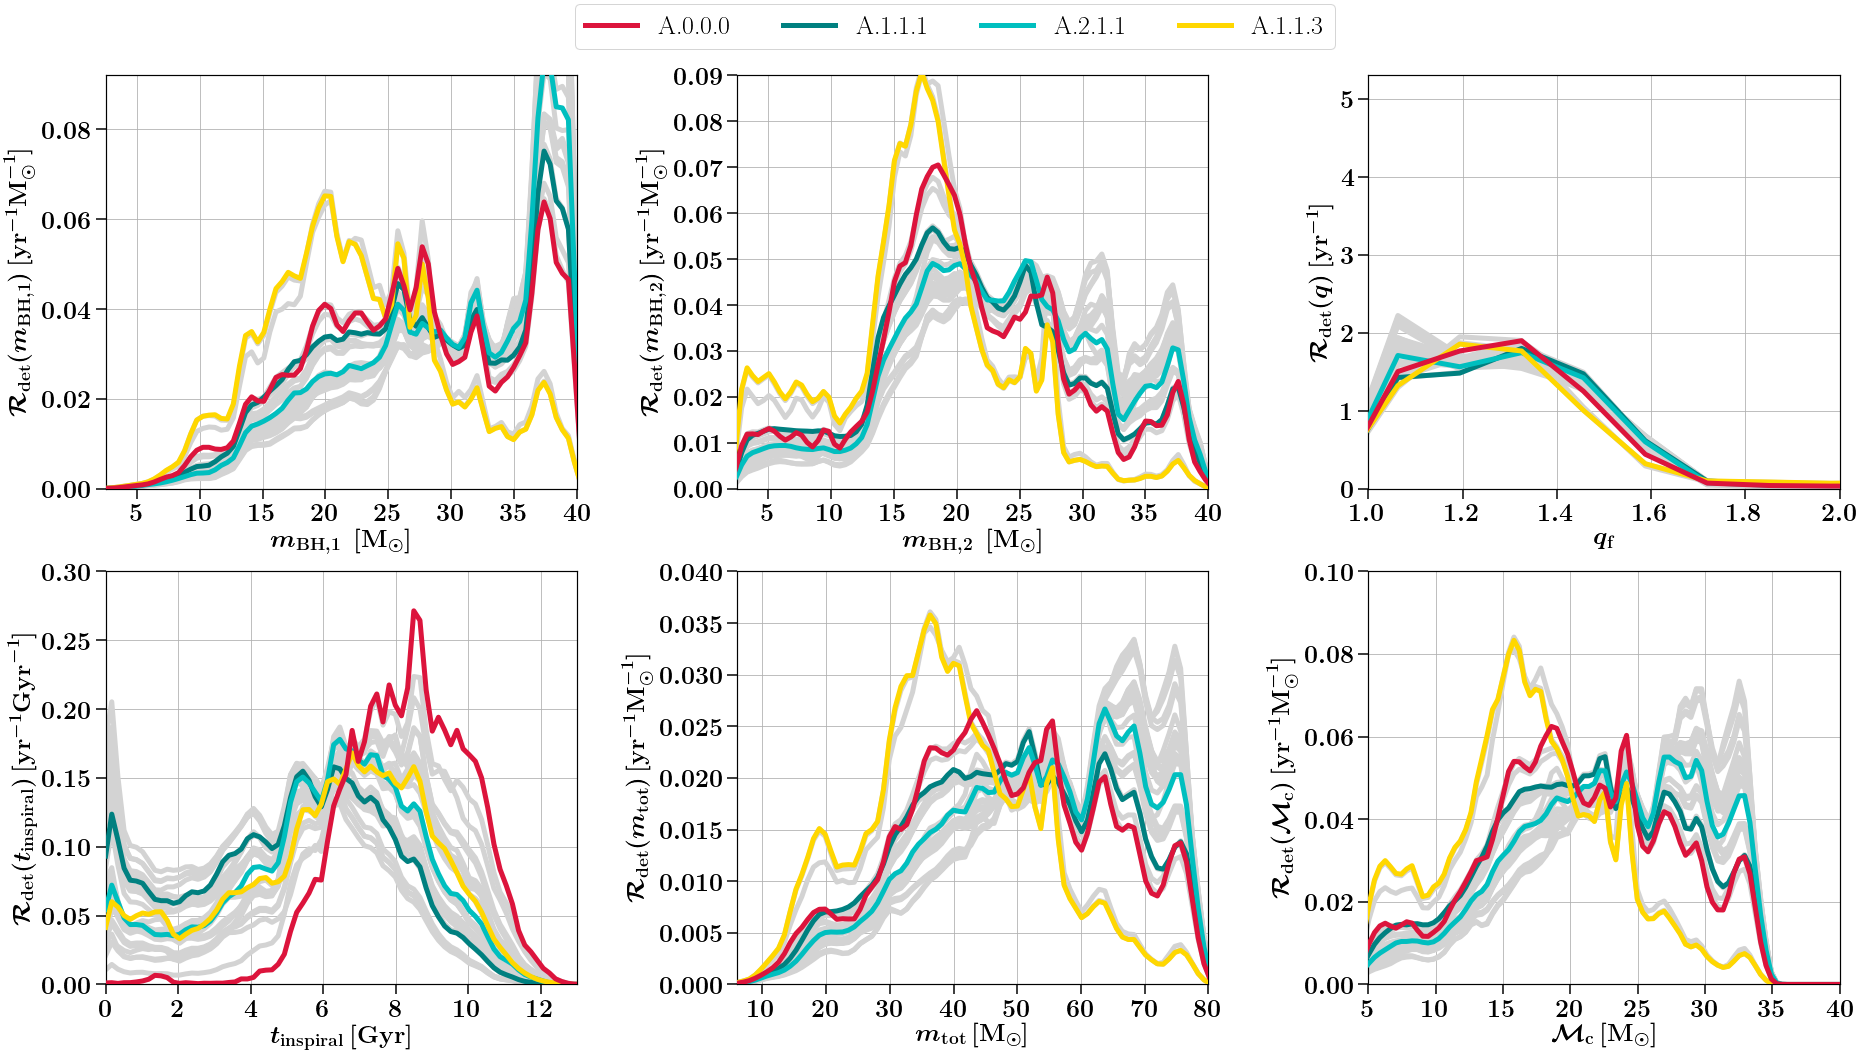

In [189]:
modelcolors = sns.color_palette("husl", len(labelslist)) 
# modelcolors=modelnameslistcolours
# BNS 
# dictChannelsList = ['classic',  'double-core CE', 'other']    
    
linewidth=3.5
ALPHA=0

f, ax= plt.subplots(ncols=3,nrows=2,figsize=(26,14), 
                  gridspec_kw={"width_ratios":[1.5, 1.5,1.5], "height_ratios":[2,2]})



#general
Nbins= .06 #.05#50 #.1 #50




####### BH MASS 

Data = Data_model1_BBH
M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

# rate_disrupted = np.zeros(4)
# # CHECK EJECTA MASS? 
# ii=0
# allweight = np.sum(Data.PerSystemPerRedshift_ratesObserved*Data.COMPAS.weight, axis=0)
# for ind_chi, chi in enumerate([0.0, 0.5]):
#     BH_chi   = chi * np.ones_like(MNS)
#     for ind_Rns, NSradii in enumerate([11.5,13.0]):
#         Rns = NSradii
#         NS_radii = Rns * np.ones_like(MNS)

#         Mej = calculateEjectedMassMerger(m_ns=MNS, r_ns=NS_radii, m_bh=MBH, Xeff=BH_chi)

#         maskEjecta = (Mej > 0)


#         combinedweight = np.sum(Data.PerSystemPerRedshift_ratesObserved*Data.COMPAS.weight, axis=0)[maskEjecta]
        
#         rate_disrupted[ii]+= np.sum(combinedweight) / np.sum(allweight)
#         ii+=1






xvar = MBH
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{BH,1}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r' $m_{\rm{BH,1}}$ $ \,  [\rm{M}_{\odot}]$'


handles, labels=plotdesigndistributionMSSFR(axe=ax[0,0], xvar=xvar, weights=rates_model1_BBH,\
                                       bandwidth=Nbins, xvarrange=[2,50], labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,40], ylim=[0,0.092], indplot=0) 


####### NS MASS 
xvar = MNS
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{BH,2}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{BH,2}}$   $ \,  [\rm{M}_{\odot}]$ '

# _,_=plotdesigndistribution(axe=ax[0,1], xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
#                               xlim=[1.2,2.5], ylim=[0,20], indplot=1) 


_,_=plotdesigndistributionMSSFR(axe=ax[0,1], xvar=xvar, weights=rates_model1_BBH,\
                                       bandwidth=Nbins, xvarrange=[2,45], labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,40], ylim=[0,.09], indplot=1) 


####### mass ratio
xvar = MBH/MNS
nameY = r'$\mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
nameX = r'$q_{\rm{f}}$'

_,_=plotdesigndistributionMSSFR(axe=ax[0,2], xvar=xvar,weights=rates_model1_BBH,\
                           bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,2], ylim=[0,5.3], indplot=2) 

# # ######## INSPIRAL TIME
# xvar = Data.COMPAS.tc / 1000
# nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
# nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

# _,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1_BBH,\
#                                 bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
#                               xlim=[0,13.7], ylim=[0,.4], indplot=3) 



# # ######## INSPIRAL TIME
xvar = Data.COMPAS.tc / 1000
nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

_,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1_BBH,\
                                bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[0,13], ylim=[0,.3], indplot=3) 



# xvar = np.log10(Data.COMPAS.tc / 1000)
# nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
# nameX = r'$\log_{10} t_{\rm{inspiral}} \, [\rm{Gyr}]$'

# _,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1_BBH,\
#                                 bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
#                               xlim=[-4,3], ylim=[0,.4], indplot=3) 





# ####### mass total
xvar = MBH+MNS
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistributionMSSFR(axe=ax[1,1], xvar=xvar,weights=rates_model1_BBH,\
                           bandwidth=Nbins, xvarrange=None, labellist=modelnameslist,xlabel=nameX, ylabel=nameY, \
                              xlim=[6,80], ylim=[0,0.04], indplot=4) 


# ####### mass chirp
xvar = chirpmass(MBH, MNS)

nameY = r'$\mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'
# nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'


_,_=plotdesigndistributionMSSFR(axe=ax[1,2], xvar=xvar,weights=rates_model1_BBH,\
                           bandwidth=Nbins, xvarrange=None, labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[5,40], ylim=[0,0.1], indplot=5) 

# # ###########


# LEGEND
lgd = f.legend(handles, labels, fontsize=fs+2, ncol=4,\
         bbox_to_anchor=(.72, 1.06),  markerscale=5., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./ObservedDistributionsFiducial_MSSFR_gaussianKDE_highlight_BBH.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
# plt.close()



# (axe, xvar, bandwidth,  xlabel, ylabel, xlim, ylim, indplot)





In [186]:

# import ClassFormationChannels as FC 

fcmodel1_BBH = FC.FormationChannels(path = pathCOMPASOutput,verbose=False)


fcmodel1_BBH.formationChannelsSeeds(seeds=Data_model1_BBH.COMPAS.seeds, withinHubbleTime=True, optimistic=False)





channelSystems  = np.ones(len(fcmodel1_BBH.rankArray)) * -1


# BHNS
for nrC, Channel in enumerate(dictChannelsBBHList):
    subchannel = np.asarray(dictChannelsBBH[Channel]) -1.
    for nrc, nr_subchannel in enumerate(subchannel):

    
        channelSystems[(fcmodel1_BBH.rankArray == nr_subchannel)] =nrC
    
# 4 = is "other channels"
channelSystems[(channelSystems ==-1.)] =4


print np.unique(channelSystems)

(52190.03630234331, 'sum sorted counts')
[0. 1. 2. 3. 4.]


In [116]:

Data = Data_model1_BBH

for ind_MSSFR, MSSFR_rate in enumerate(rates_model1_BBH):
    print('--------------------------')
    print('now at MSSFR index =', ind_MSSFR)
    # BNS 
    # dictChannelsList = ['classic',  'double-core CE', 'other']    

    linewidth=3.5
    ALPHA=0


    f, ax= plt.subplots(ncols=2,nrows=3,figsize=(20,23), 
                      gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2,2]})


    #general
    Nbins= .06 #.05#50 #.1 #50




    ####### BH MASS 
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)



    xvar = MBH
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'

    handles, labels=plotdesigndistribution(axe=ax[0,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[2.5,40], ylim=[0,.22], indplot=0, ind_MSSFR=ind_MSSFR) 


    ####### NS MASS 
    xvar = MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{BH,1}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$m_{\rm{BH,2}}$   $ \,  [\rm{M}_{\odot}]$ '

    _,_=plotdesigndistribution(axe=ax[0,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[2.5,40], ylim=[0,5], indplot=1, ind_MSSFR=ind_MSSFR) 




    ####### mass ratio
    xvar = MBH/MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
    nameX = r'$q$'

    _,_=plotdesigndistribution(axe=ax[1,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,3], ylim=[0,.31], indplot=2, ind_MSSFR=ind_MSSFR) 

    ######## INSPIRAL TIME
    xvar = Data.COMPAS.tc / 1000
    nameY = r'$ \mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
    nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

    _,_=plotdesigndistribution(axe=ax[1,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[0,13.7], ylim=[0,0.37], indplot=3, ind_MSSFR=ind_MSSFR) 




    ####### mass total
    xvar = MBH+MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

    _,_=plotdesigndistribution(axe=ax[2,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[6,80], ylim=[0,0.22], indplot=4, ind_MSSFR=ind_MSSFR) 


    ####### mass chirp
    xvar = chirpmass(MBH, MNS)
    nameY = r'$ \mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'

    _,_=plotdesigndistribution(axe=ax[2,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[5,40], ylim=[0,0.55], indplot=5, ind_MSSFR=ind_MSSFR) 

    # ###########


    # LEGEND
    lgd = f.legend(handles, labels, fontsize=fs, ncol=3,\
             bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




    plt.tight_layout()
    plt.subplots_adjust(wspace=0.34, hspace=0.2)
    plt.savefig('./images_MSSFR_Fiducial_observedPredictions/ObservedDistributionsFiducial_BBH_m'+str(ind_MSSFR)+'.png', dpi=100, transparent=False,\
               bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.show()

    plt.close()



    # (axe, xvar, bandwidth,  xlabel, ylabel, xlim, ylim, indplot)





NameError: name 'Data_model1_BBH' is not defined

In [191]:
filenames = []
for ind_MSSFR, MSSFRrate in enumerate(rates_model1_BBH):
    filenames.append('./ObservedDistributionsFiducial_BBH_m'+ str(ind_MSSFR) +'.png')


import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('./images_MSSFR_Fiducial_observedPredictions/'+filename))
imageio.mimsave('./images_MSSFR_Fiducial_observedPredictions/MSSFRmovieFiducial_BBH.gif', images)

# BNS

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[1.27767 1.27762 1.2777  ... 1.27763 1.27764 1.28488]
38183
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)


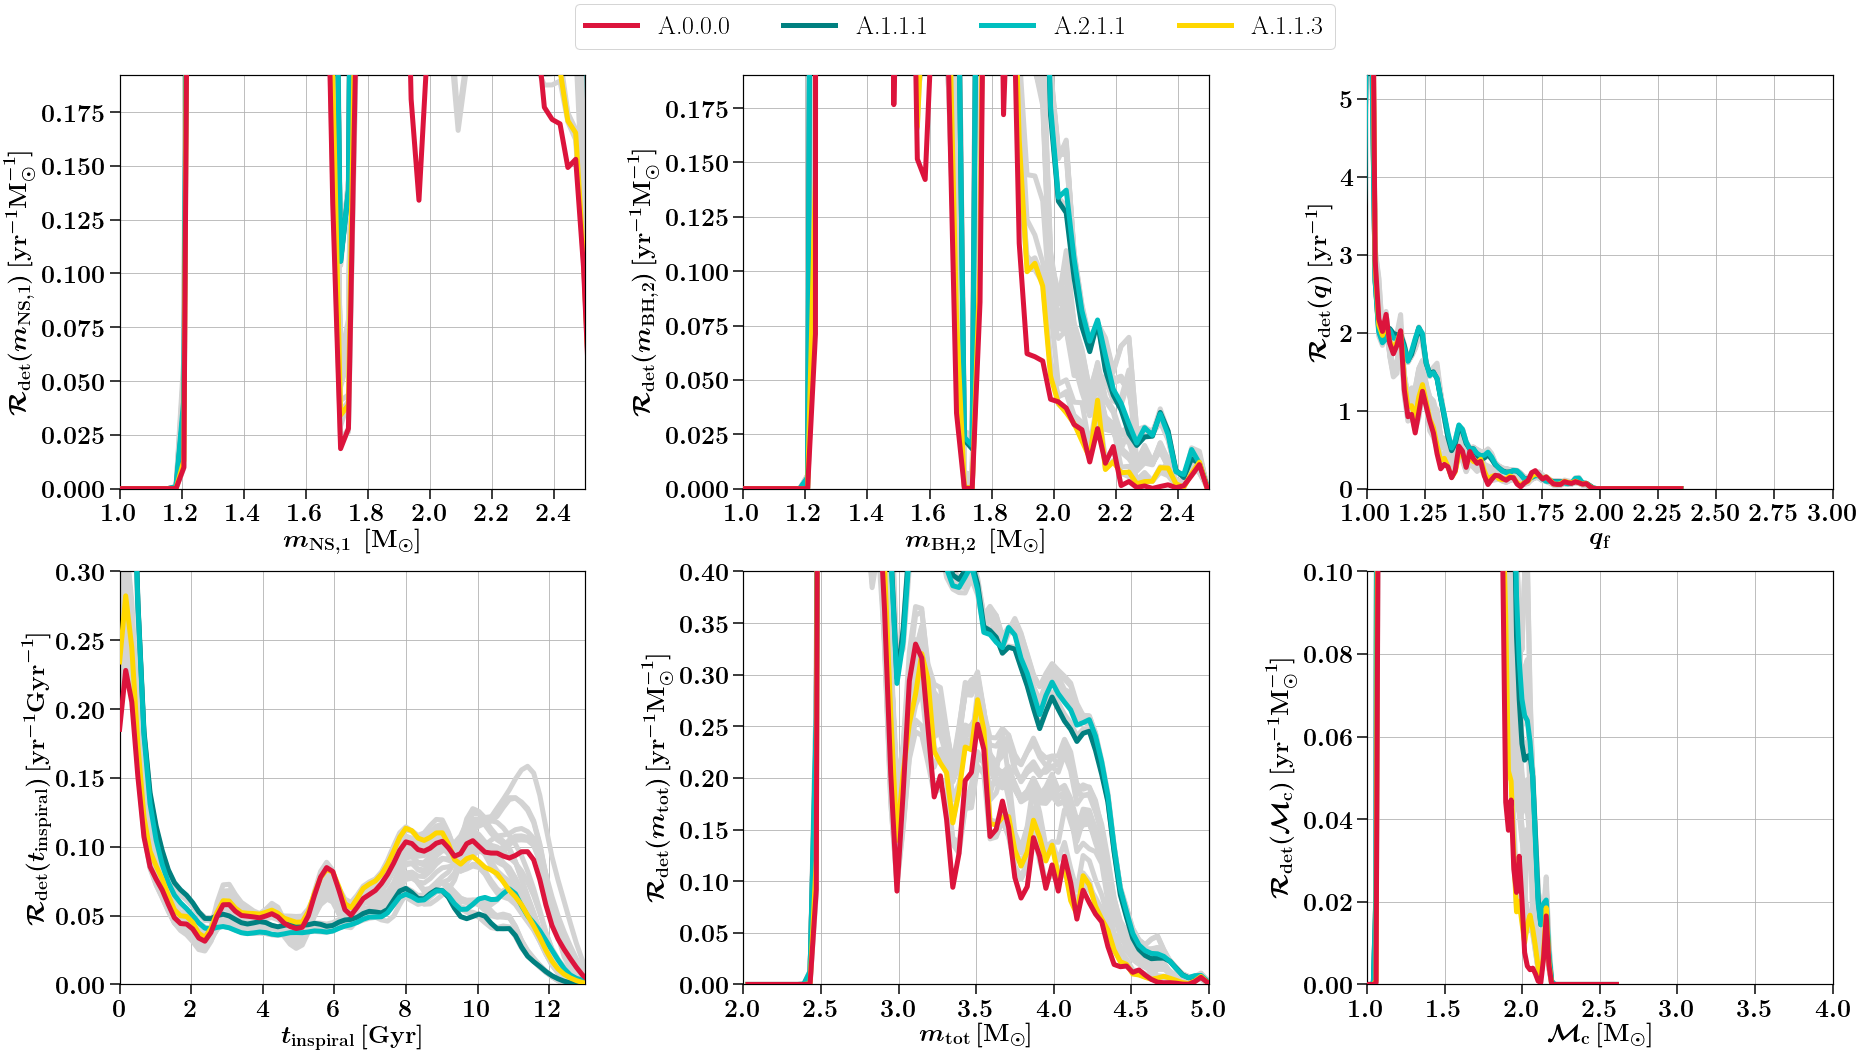

(17723.294151464976, 'sum sorted counts')


NameError: name 'dictChannelsBNSList' is not defined

In [192]:


#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
modelname = 'Fiducial'
#Will only look at BNSs so might as well set everything
minz = 0.
maxz = 2.
resz = 100
TYPE ='BNS'
Data_model1_BNS = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model1_BNS.COMPAS.mass1)
print(len(Data_model1_BNS.COMPAS.mass1))


#######


rates_model1    = []
totals_model1   = []


method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']



rates_model1_BNS    = []
totals_model1_BNS   = []
# labelslist_BNS = []

GSMFs = ['Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Furlong et al. (2015) Double']
MZs   = [ 'Langer et al. (2006)'      , 'Langer et al. +offset (2006)', 'Ma et al. (2015)']
SFRs  = ['Madau et al. (2014)'         ,'Strolger et al. (2004)',     'Madau et al. (2017)']


# Neijssel:
         
Data_model1_BNS.MSSFR.Zprescription         = 'logNormal' 
Data_model1_BNS.MSSFR.SFRprescription       = 'Neijssel et al. (2019)'
Data_model1_BNS.MSSFR.logNormalPrescription = 'Neijssel Phenomenological'
Data_model1_BNS.MSSFR.GSMFprescription      = None
Data_model1_BNS.MSSFR.ZMprescription        = None
Data_model1_BNS.cosmologicalIntegration()
weightSTROOPWAFEL = Data_model1_BNS.COMPAS.weight # //floor weight
Row        =  np.sum(Data_model1_BNS.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model1_BNS.PerSystemPerRedshift_ratesObserved, axis=0)
rates_model1_BNS.append(Row)
totals_model1_BNS.extend([np.sum(Row)])
labelslist.append('Neijssel 2019')
for ind_GSMF, GSMF in enumerate(GSMFs):
         for ind_MZ, MZ in enumerate(MZs):
             for ind_SFR, SFR in enumerate(SFRs):
                 
                Data_model1_BNS.MSSFR.Zprescription         = 'MZ_GSMF'
                Data_model1_BNS.MSSFR.SFRprescription       = SFR
#                 Data_model1_BNS.MSSFR.logNormalPrescription = logNormal[nrL]
                Data_model1_BNS.MSSFR.GSMFprescription      = GSMF
                Data_model1_BNS.MSSFR.ZMprescription        = MZ
                Data_model1_BNS.cosmologicalIntegration()
                weightSTROOPWAFEL_BNS = Data_model1_BNS.COMPAS.weight # //floor weight
                Row        =  np.sum(Data_model1_BNS.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL_BNS, axis=0) # //floor weight
            #     Row        =np.sum(Data_model1_BNS.PerSystemPerRedshift_ratesObserved, axis=0)
                rates_model1_BNS.append(Row)
                totals_model1_BNS.extend([np.sum(Row)])
         
#                 labelslist.append(SFR + r'$\_+\_' + GSMF + r'$\_+\_' + MZ )
                
         


('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)
('at ind =', 1)
('at ind =', 11)
('at ind =', 21)


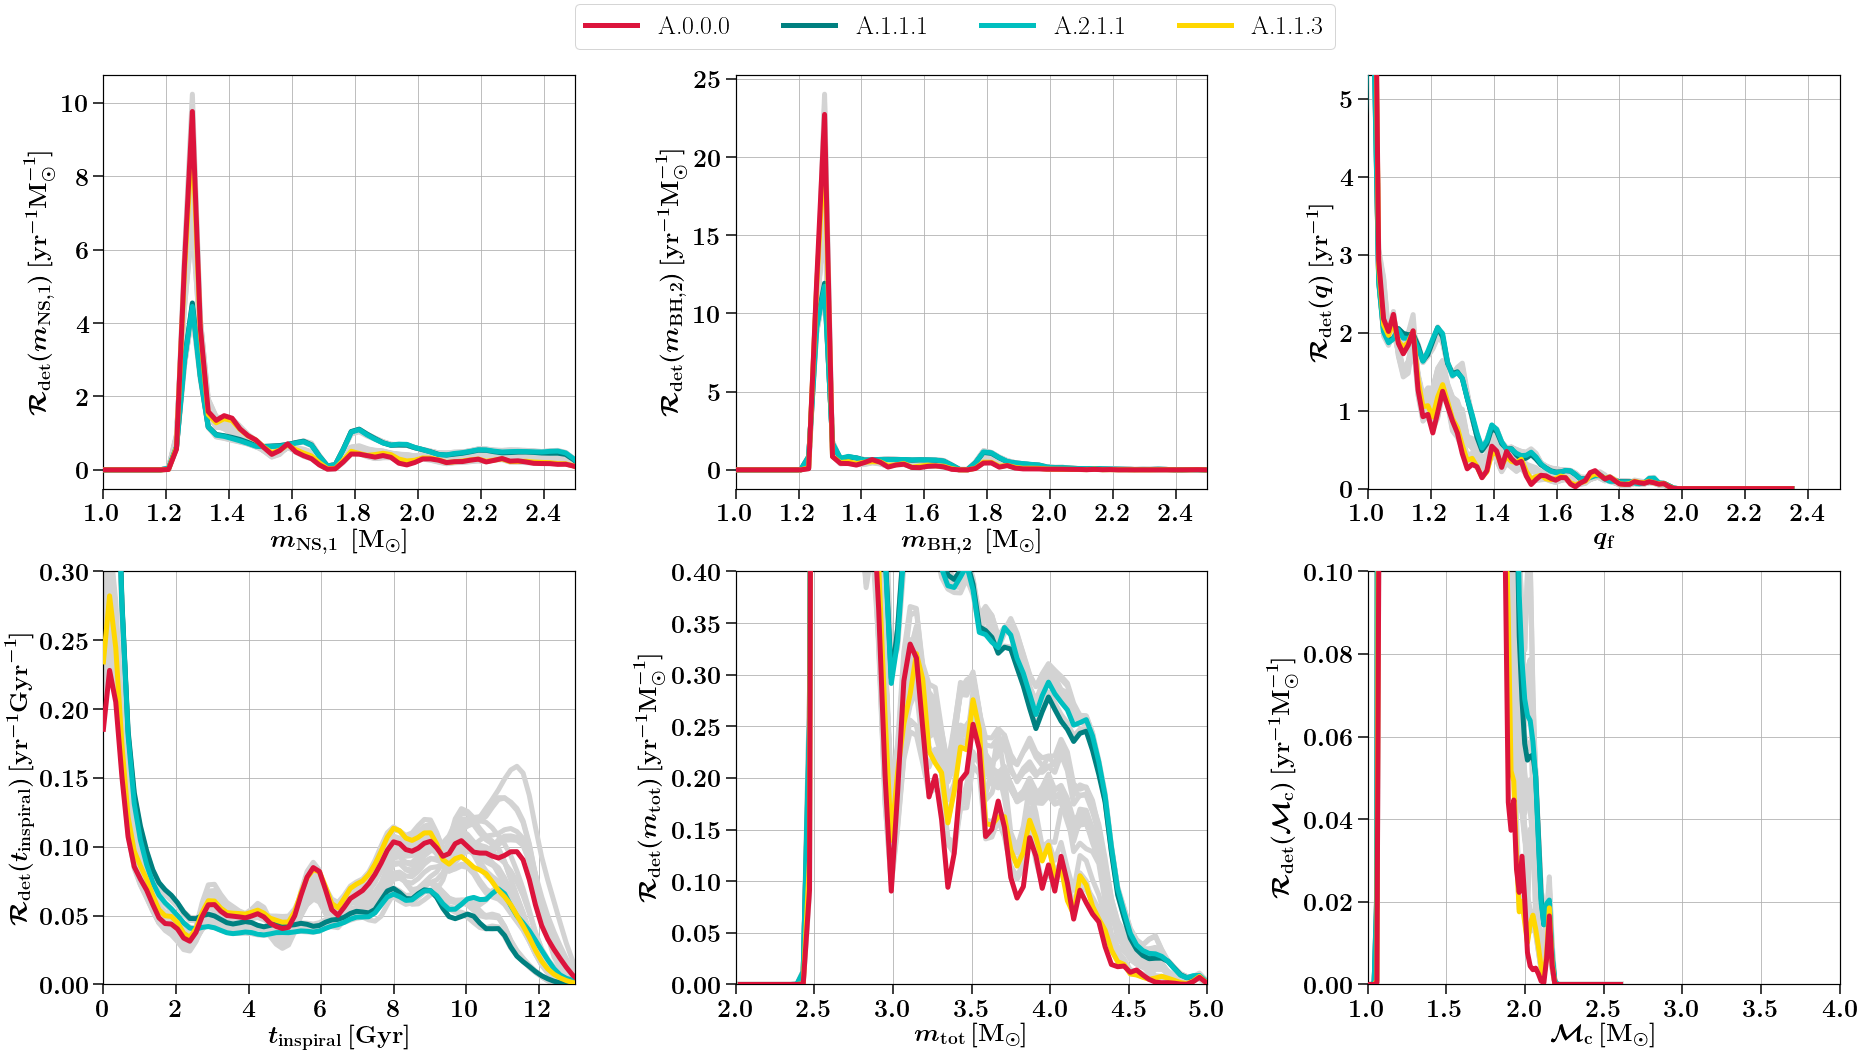

In [195]:
###################################
###################################
###################################
###################################
###################################


modelcolors = sns.color_palette("husl", len(labelslist)) 
# modelcolors=modelnameslistcolours
# BNS 
# dictChannelsList = ['classic',  'double-core CE', 'other']    
    
linewidth=3.5
ALPHA=0

f, ax= plt.subplots(ncols=3,nrows=2,figsize=(26,14), 
                  gridspec_kw={"width_ratios":[1.5, 1.5,1.5], "height_ratios":[2,2]})



#general
Nbins= .06 #.05#50 #.1 #50




####### BH MASS 

Data = Data_model1_BNS
M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

# rate_disrupted = np.zeros(4)
# # CHECK EJECTA MASS? 
# ii=0
# allweight = np.sum(Data.PerSystemPerRedshift_ratesObserved*Data.COMPAS.weight, axis=0)
# for ind_chi, chi in enumerate([0.0, 0.5]):
#     BH_chi   = chi * np.ones_like(MNS)
#     for ind_Rns, NSradii in enumerate([11.5,13.0]):
#         Rns = NSradii
#         NS_radii = Rns * np.ones_like(MNS)

#         Mej = calculateEjectedMassMerger(m_ns=MNS, r_ns=NS_radii, m_bh=MBH, Xeff=BH_chi)

#         maskEjecta = (Mej > 0)


#         combinedweight = np.sum(Data.PerSystemPerRedshift_ratesObserved*Data.COMPAS.weight, axis=0)[maskEjecta]
        
#         rate_disrupted[ii]+= np.sum(combinedweight) / np.sum(allweight)
#         ii+=1






xvar = MBH
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{NS,1}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r' $m_{\rm{NS,1}}$ $ \,  [\rm{M}_{\odot}]$'


handles, labels=plotdesigndistributionMSSFR(axe=ax[0,0], xvar=xvar, weights=rates_model1_BNS,\
                                       bandwidth=Nbins, xvarrange=[.5,3], labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,2.5], ylim=None, indplot=0) 


####### NS MASS 
xvar = MNS
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{BH,2}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{BH,2}}$   $ \,  [\rm{M}_{\odot}]$ '

# _,_=plotdesigndistribution(axe=ax[0,1], xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
#                               xlim=[1.2,2.5], ylim=[0,20], indplot=1) 


_,_=plotdesigndistributionMSSFR(axe=ax[0,1], xvar=xvar, weights=rates_model1_BNS,\
                                       bandwidth=Nbins, xvarrange=[0.5,3], labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,2.5], ylim=None, indplot=1) 


####### mass ratio
xvar = MBH/MNS
nameY = r'$\mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
nameX = r'$q_{\rm{f}}$'

_,_=plotdesigndistributionMSSFR(axe=ax[0,2], xvar=xvar,weights=rates_model1_BNS,\
                           bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,2.5], ylim=[0,5.3], indplot=2) 

# # ######## INSPIRAL TIME
# xvar = Data.COMPAS.tc / 1000
# nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
# nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

# _,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1_BNS,\
#                                 bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
#                               xlim=[0,13.7], ylim=[0,.4], indplot=3) 



# # ######## INSPIRAL TIME
xvar = Data.COMPAS.tc / 1000
nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

_,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1_BNS,\
                                bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[0,13], ylim=[0,.3], indplot=3) 



# xvar = np.log10(Data.COMPAS.tc / 1000)
# nameY = r'$\mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
# nameX = r'$\log_{10} t_{\rm{inspiral}} \, [\rm{Gyr}]$'

# _,_=plotdesigndistributionMSSFR(axe=ax[1,0], xvar=xvar,weights=rates_model1_BNS,\
#                                 bandwidth=Nbins, xvarrange=None,  labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
#                               xlim=[-4,3], ylim=[0,.4], indplot=3) 





# ####### mass total
xvar = MBH+MNS
nameY = r'$\mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistributionMSSFR(axe=ax[1,1], xvar=xvar,weights=rates_model1_BNS,\
                           bandwidth=Nbins, xvarrange=None, labellist=modelnameslist,xlabel=nameX, ylabel=nameY, \
                              xlim=[2,5], ylim=[0,0.4], indplot=4) 


# ####### mass chirp
xvar = chirpmass(MBH, MNS)

nameY = r'$\mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'
# nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'


_,_=plotdesigndistributionMSSFR(axe=ax[1,2], xvar=xvar,weights=rates_model1_BNS,\
                           bandwidth=Nbins, xvarrange=None, labellist=modelnameslist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,4], ylim=[0,0.1], indplot=5) 

# # ###########


# LEGEND
lgd = f.legend(handles, labels, fontsize=fs+2, ncol=4,\
         bbox_to_anchor=(.72, 1.06),  markerscale=5., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./ObservedDistributionsFiducial_MSSFR_gaussianKDE_highlight_BNS.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
# plt.close()



# (axe, xvar, bandwidth,  xlabel, ylabel, xlim, ylim, indplot)







In [ ]:

###################################
###################################
###################################
###################################
###################################

# import ClassFormationChannels as FC 

fcmodel1_BNS = FC.FormationChannels(path = pathCOMPASOutput,verbose=False)


fcmodel1_BNS.formationChannelsSeeds(seeds=Data_model1_BNS.COMPAS.seeds, withinHubbleTime=True, optimistic=False)






In [117]:


channelSystems  = np.ones(len(fcmodel1_BNS.rankArray)) * -1


# BHNS
for nrC, Channel in enumerate(dictChannelsBHNSList):
    subchannel = np.asarray(dictChannelsBNS[Channel]) -1.
    for nrc, nr_subchannel in enumerate(subchannel):

    
        channelSystems[(fcmodel1_BNS.rankArray == nr_subchannel)] =nrC
    
# 4 = is "other channels"
channelSystems[(channelSystems ==-1.)] =4


print np.unique(channelSystems)




###################################
###################################
###################################
###################################
###################################






Data = Data_model1_BNS

for ind_MSSFR, MSSFR_rate in enumerate(rates_model1_BNS):
    print('--------------------------')
    print('now at MSSFR index =', ind_MSSFR)
    # BNS 
    # dictChannelsList = ['classic',  'double-core CE', 'other']    

    linewidth=3.5
    ALPHA=0


    f, ax= plt.subplots(ncols=2,nrows=3,figsize=(20,23), 
                      gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2,2]})


    #general
    Nbins= .06 #.05#50 #.1 #50




    ####### BH MASS 
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)



    xvar = MBH
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{NS,1}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r' $m_{\rm{NS,1}}$ $ \,  [\rm{M}_{\odot}]$'

    handles, labels=plotdesigndistribution(axe=ax[0,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,2.5], ylim=[0,.22], indplot=0, ind_MSSFR=ind_MSSFR) 


    ####### NS MASS 
    xvar = MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{NS,2}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$m_{\rm{NS,2}}$   $ \,  [\rm{M}_{\odot}]$ '

    _,_=plotdesigndistribution(axe=ax[0,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,2.5], ylim=[0,5], indplot=1, ind_MSSFR=ind_MSSFR) 




    ####### mass ratio
    xvar = MBH/MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
    nameX = r'$q$'

    _,_=plotdesigndistribution(axe=ax[1,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,2.5], ylim=[0,.31], indplot=2, ind_MSSFR=ind_MSSFR) 

    ######## INSPIRAL TIME
    xvar = Data.COMPAS.tc / 1000
    nameY = r'$ \mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
    nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

    _,_=plotdesigndistribution(axe=ax[1,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[0,13.7], ylim=[0,0.37], indplot=3, ind_MSSFR=ind_MSSFR) 




    ####### mass total
    xvar = MBH+MNS
    nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

    _,_=plotdesigndistribution(axe=ax[2,0], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[2,5], ylim=[0,0.22], indplot=4, ind_MSSFR=ind_MSSFR) 


    ####### mass chirp
    xvar = chirpmass(MBH, MNS)
    nameY = r'$ \mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
    nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'

    _,_=plotdesigndistribution(axe=ax[2,1], xvar=xvar, weights=MSSFR_rate, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                                  xlim=[1,2], ylim=[0,0.55], indplot=5, ind_MSSFR=ind_MSSFR) 

    # ###########


    # LEGEND
    lgd = f.legend(handles, labels, fontsize=fs, ncol=3,\
             bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




    plt.tight_layout()
    plt.subplots_adjust(wspace=0.34, hspace=0.2)
    plt.savefig('./images_MSSFR_Fiducial_observedPredictions/ObservedDistributionsFiducial_BNS_m'+str(ind_MSSFR)+'.png', dpi=100, transparent=False,\
               bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.show()

    plt.close()



    # (axe, xvar, bandwidth,  xlabel, ylabel, xlim, ylim, indplot)



filenames = []
for ind_MSSFR, MSSFRrate in enumerate(rates_model1_BNS):
    filenames.append('./ObservedDistributionsFiducial_BNS_m'+ str(ind_MSSFR) +'.png')


import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('./images_MSSFR_Fiducial_observedPredictions/'+filename))
imageio.mimsave('./images_MSSFR_Fiducial_observedPredictions/MSSFRmovieFiducial_BNS.gif', images)



NameError: name 'fcmodel1_BNS' is not defined

# Varying MODELS 

In [196]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['A.0.0.0'                  , 'A.1.1.1'                    , 'A.2.1.1'                     , 'A.1.1.3']





In [197]:
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/Fiducial/'
modelname = 'A'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
TYPE='BHNS'
Data_modelA = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_modelA.COMPAS.mass1)
print(len(Data_modelA.COMPAS.mass1))




rates_modelA    = []
totals_modelA   = []
for nrL, L in enumerate(labels):
    Data_modelA.MSSFR.Zprescription         = method[nrL]
    Data_modelA.MSSFR.SFRprescription       = SFRs[nrL]
    Data_modelA.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_modelA.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_modelA.MSSFR.ZMprescription        = MZs[nrL]
    Data_modelA.cosmologicalIntegration()
        
    weight_modelA = Data_modelA.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_modelA.PerSystemPerRedshift_ratesObserved*weight_modelA, axis=0) # //floor weight

    
#     Row        =np.sum(Data_modelA.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_modelA.append(Row)
    totals_modelA.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[2.06203 9.0769  2.98903 ... 4.78319 4.4085  4.66631]
1366530
('A.0.0.0', 6.627242909431183)
('A.1.1.1', 37.42908360837859)
('A.2.1.1', 37.18752595517152)
('A.1.1.3', 11.516053253000695)


In [ ]:
# MODEL B

In [198]:
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/alpha0_1/'
modelname = 'B'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
TYPE='BHNS'
Data_modelB = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_modelB.COMPAS.mass1)
print(len(Data_modelB.COMPAS.mass1))




rates_modelB    = []
totals_modelB   = []
for nrL, L in enumerate(labels):
    Data_modelB.MSSFR.Zprescription         = method[nrL]
    Data_modelB.MSSFR.SFRprescription       = SFRs[nrL]
    Data_modelB.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_modelB.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_modelB.MSSFR.ZMprescription        = MZs[nrL]
    Data_modelB.cosmologicalIntegration()
        
    weight_modelB = Data_modelB.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_modelB.PerSystemPerRedshift_ratesObserved*weight_modelB, axis=0) # //floor weight

    
#     Row        =np.sum(Data_modelB.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_modelB.append(Row)
    totals_modelB.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[2.04871 1.35708 1.31002 ... 6.16676 4.9449  6.16654]
50208
('A.0.0.0', 1.0892210896097192)
('A.1.1.1', 5.167909211649317)
('A.2.1.1', 4.968244240368928)
('A.1.1.3', 1.8700212783938)


In [ ]:
# model C alpha = 10 

In [199]:
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/alpha_10/'
modelname = 'C'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
TYPE='BHNS'
Data_modelC = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_modelC.COMPAS.mass1)
print(len(Data_modelC.COMPAS.mass1))




rates_modelC    = []
totals_modelC   = []
for nrL, L in enumerate(labels):
    Data_modelC.MSSFR.Zprescription         = method[nrL]
    Data_modelC.MSSFR.SFRprescription       = SFRs[nrL]
    Data_modelC.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_modelC.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_modelC.MSSFR.ZMprescription        = MZs[nrL]
    Data_modelC.cosmologicalIntegration()
        
    weight_modelC = Data_modelC.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_modelC.PerSystemPerRedshift_ratesObserved*weight_modelC, axis=0) # //floor weight

    
#     Row        =np.sum(Data_modelC.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_modelC.append(Row)
    totals_modelC.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[3.40435 4.77606 1.27758 ... 6.16676 4.9449  6.16654]
275375
('A.0.0.0', 1.7901563726536796)
('A.1.1.1', 13.584886985827767)
('A.2.1.1', 17.98565229453803)
('A.1.1.3', 2.2559436817352974)


# MODEL D  RAPID

In [204]:
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/rapid/'
modelname = 'D'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
TYPE='BHNS'
Data_modelD = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_modelD.COMPAS.mass1)
print(len(Data_modelD.COMPAS.mass1))




rates_modelD    = []
totals_modelD   = []
for nrL, L in enumerate(labels):
    Data_modelD.MSSFR.Zprescription         = method[nrL]
    Data_modelD.MSSFR.SFRprescription       = SFRs[nrL]
    Data_modelD.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_modelD.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_modelD.MSSFR.ZMprescription        = MZs[nrL]
    Data_modelD.cosmologicalIntegration()
        
    weight_modelD = Data_modelD.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_modelD.PerSystemPerRedshift_ratesObserved*weight_modelD, axis=0) # //floor weight

    
#     Row        =np.sum(Data_modelD.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_modelD.append(Row)
    totals_modelD.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[12.1964   1.10794 14.4124  ...  6.02015  7.918    7.14927]
2961411
('A.0.0.0', 14.40200608964753)
('A.1.1.1', 57.90729318483064)
('A.2.1.1', 55.96319057617453)
('A.1.1.3', 23.82061633759291)


# MODEL E  Optmistic

In [202]:
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/Fiducial/'
modelname = 'E'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
TYPE='BHNS'
Data_modelE = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=True, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_modelE.COMPAS.mass1)
print(len(Data_modelE.COMPAS.mass1))




rates_modelE    = []
totals_modelE   = []
for nrL, L in enumerate(labels):
    Data_modelE.MSSFR.Zprescription         = method[nrL]
    Data_modelE.MSSFR.SFRprescription       = SFRs[nrL]
    Data_modelE.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_modelE.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_modelE.MSSFR.ZMprescription        = MZs[nrL]
    Data_modelE.cosmologicalIntegration()
        
    weight_modelE = Data_modelE.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_modelE.PerSystemPerRedshift_ratesObserved*weight_modelE, axis=0) # //floor weight

    
#     Row        =np.sum(Data_modelE.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_modelE.append(Row)
    totals_modelE.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[2.45955 2.06203 9.0769  ... 3.53668 4.66631 3.34219]
1407608
('A.0.0.0', 13.668090889924487)
('A.1.1.1', 58.574709188994284)
('A.2.1.1', 57.94488800417434)
('A.1.1.3', 22.104254456828063)


In [78]:
def plotdesigndistributionModels(axe, xvarlist, weightslist, bandwidth, xvarrange, labellist, xlabel, ylabel, xlim, ylim, indplot):
    """ plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """


    axes = [axe]
    


    res_kde =100 # resolution kde, just the nr of interpolation points (so this is not the bandwith). 
    if xvarrange:
        xx_boot = np.linspace(xvarrange[0], xvarrange[1], res_kde)
    else:
        xx_boot = np.linspace(min(xvar)*0.8,max(xvar)*1.2, res_kde)
    
    
#     model_1list = [1,2,3,10,11,12,19,20,21] 
#     colorgreen = sns.light_palette("green",len(model_1list)) 
#     colorblue = sns.light_palette("blue",(len(labelslist)-len(model_1list)-1)) 
    ind_g, ind_b = 0,0
    
    
    for ind_m, xvar in enumerate(xvarlist):
        
        for ind_MSSFR, weights in enumerate(weightslist[ind_m]):
#             weights = weightslist[ind_m][ind_MSSFR]
            if ind_MSSFR%10==1:
                print('at ind =', ind_MSSFR)


            COLOR=modelcolors[ind_m]
            zorder=10

            if ind_MSSFR==0:
                label = labellist[ind_m]
            else:
                label = None
            
            
#             rate       = rates[nrL]
#             rate, _    = np.histogram(var_x, bins=bins, weights = rate)
#             rate       = np.divide(rate, dvar_x)
#             rate       = rate / np.sum(rate)
# #             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
# #             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
#             if nrL==0:
#                 label = modelnameslist[ind_m]
#             else:
#                 label = None
#             ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)





#             axe.hist(xvar, bins=xx_boot, weights=weights,\
#                      color=COLOR, label=label, \
#                      linewidth=4, histtype='step' , density=True, zorder=zorder, linestyle=linestyles[ind_MSSFR])
            KDE = gaussian_kde(xvar, weights=weights, bw_method = bandwidth)
            y_boot = KDE(xx_boot)



            axe.plot(xx_boot,  y_boot, c=COLOR, label=label,\
                     linewidth=5, zorder=zorder, linestyle=linestyles[ind_MSSFR])

    ###########

        
    if indplot=='log':
#         axe.set_xscale('log')
        axe.set_yscale('log')
        
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])
        
    axe == CV.layoutAxes(axe, nameX=xlabel, nameY=ylabel)

    
    if indplot==0: 
        handles, labels = axe.get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    axe.grid(True)
    
    
    return handles, labels
    

In [219]:
print(np.shape(rates_modelA[0]))
print(np.shape(xvarlist[0]))

(1366530,)
(1366530,)


('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)


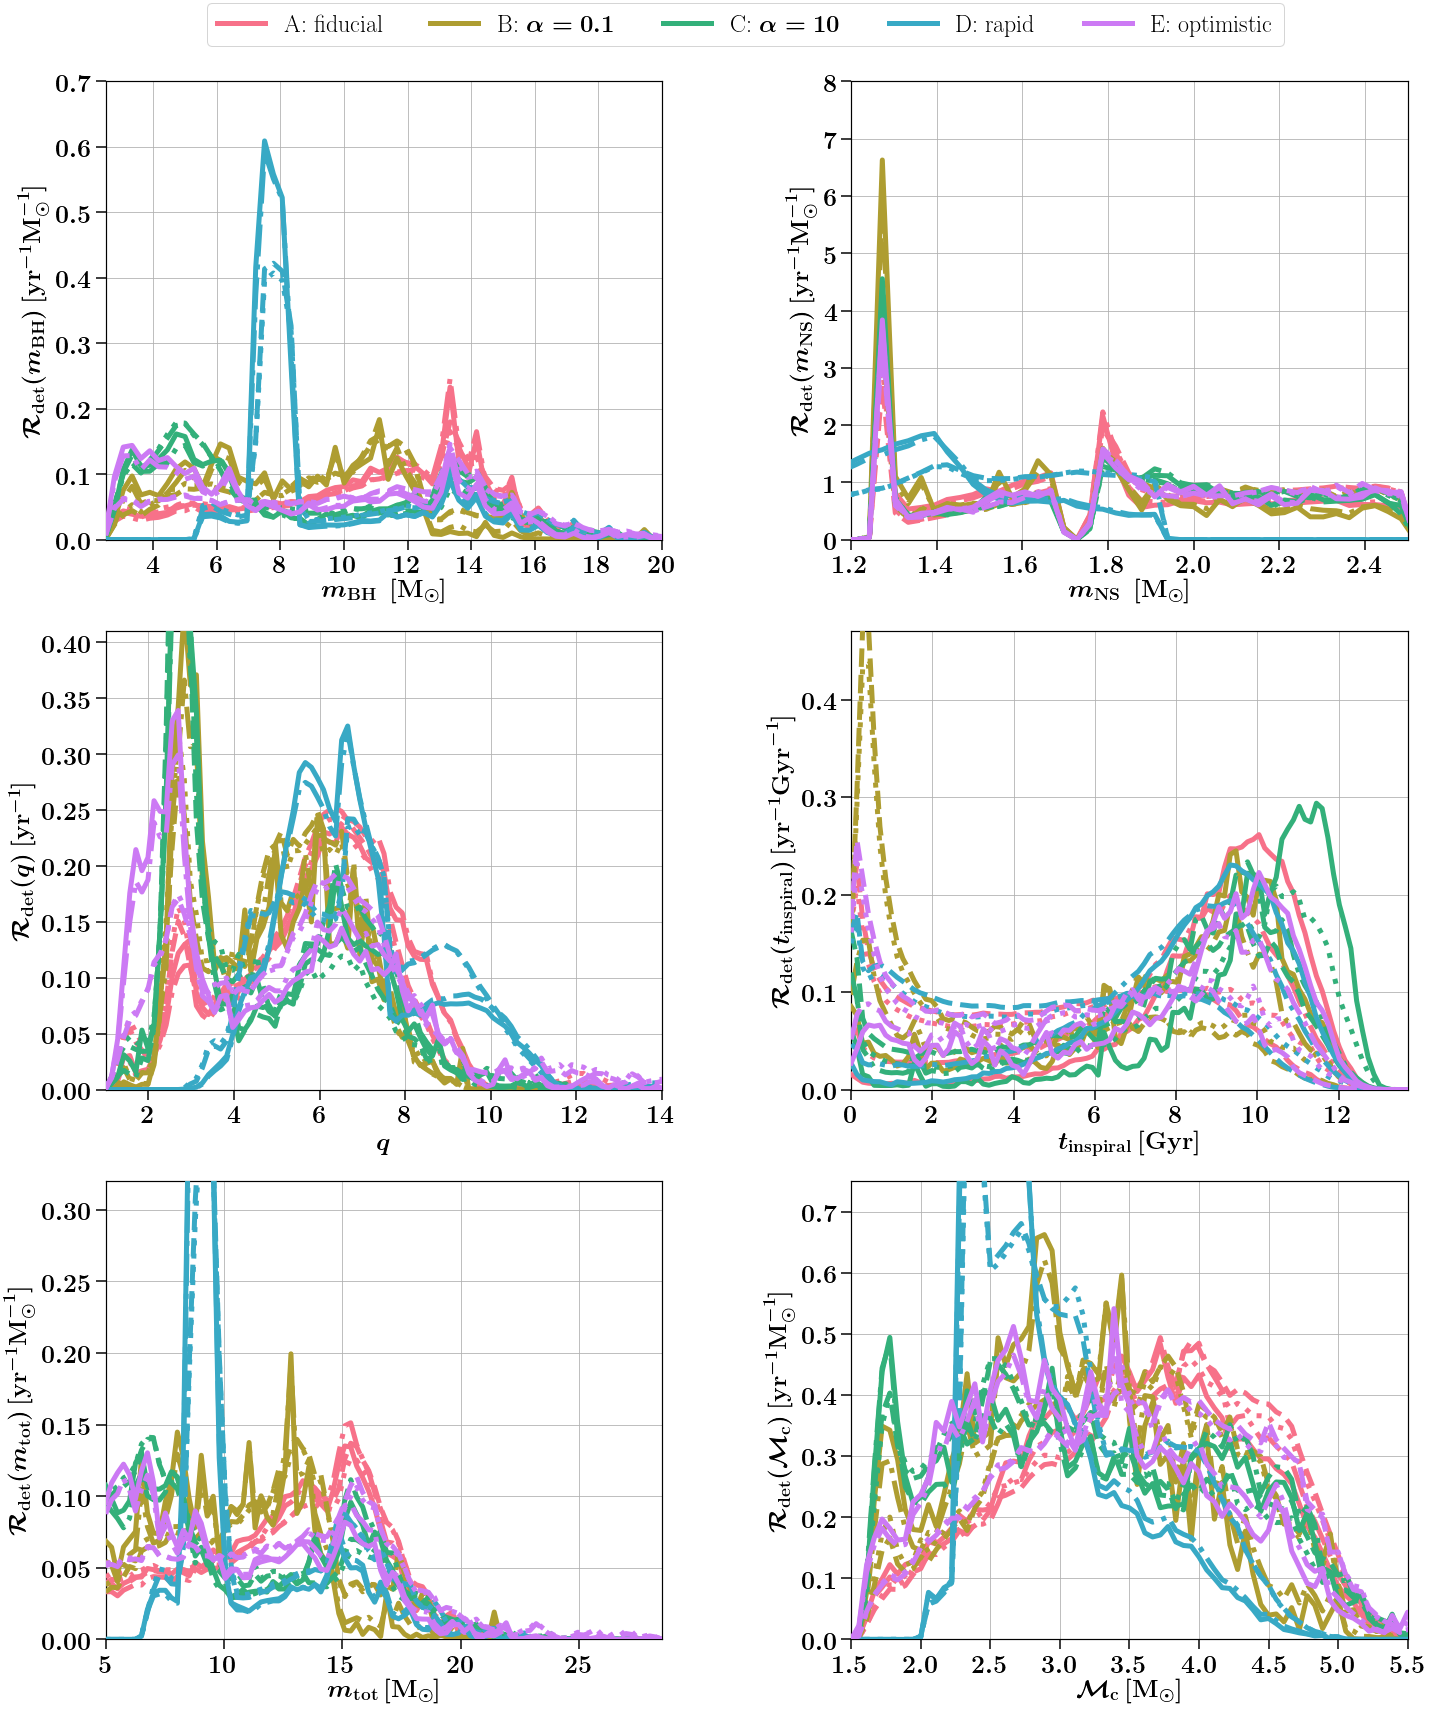

In [239]:
# Datalist = [Data_model1] #, Data_model2, Data_model3]
# modelnameslist = [r'Fiducial'] #, r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
# rateslist = [rates_model1, rates_model2, rates_model3]
# totalslist = [totals_modelA, totals_model2, totals_model3]
modelcolors = sns.color_palette("husl", 5) 


weightslist = [rates_modelA, rates_modelB, rates_modelC, rates_modelD, rates_modelE]
# labellist=modelnameslist
linewidth=3.5
ALPHA=0


f, ax= plt.subplots(ncols=2,nrows=3,figsize=(20,23), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2,2]})

labellist = [r'A: fiducial',r'B: $\alpha =0.1$',r'C: $\alpha=10$',r'D: rapid',r'E: optimistic',]
#general
Nbins= .03 #.05#50 #.1 #50


Datalist = [Data_modelA, Data_modelB, Data_modelC, Data_modelD, Data_modelE]

####### BH MASS 
xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MBH
    xvarlist.append(xvar)  


nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'

handles, labels=plotdesigndistributionModels(axe=ax[0,0], xvarlist=xvarlist, \
                                             weightslist=weightslist, bandwidth=Nbins,\
                                             xvarrange=[2.5,30],  labellist=labellist,\
                                             xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,20], ylim=[0,.7], indplot=0) 


# ####### NS MASS 

xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MNS
    xvarlist.append(xvar)  

# xvar = MNS
nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{NS}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{NS}}$   $ \,  [\rm{M}_{\odot}]$ '

_,_=plotdesigndistributionModels(axe=ax[0,1], xvarlist=xvarlist, weightslist=weightslist,\
                                 bandwidth=Nbins, xvarrange=[1,4] ,\
                                 labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1.2,2.5], ylim=[0,8], indplot=1) 




# ####### mass ratio
xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MBH/MNS
    xvarlist.append(xvar)  
# 
nameY = r'$ \mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
nameX = r'$q$'

_,_=plotdesigndistributionModels(axe=ax[1,0], xvarlist=xvarlist, weightslist=weightslist, bandwidth=Nbins, xvarrange=[1,15] ,labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,14], ylim=[0,.41], indplot=2) 

# ######## INSPIRAL TIME


xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = Data.COMPAS.tc / 1000
    xvarlist.append(xvar)  

nameY = r'$ \mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

_,_=plotdesigndistributionModels(axe=ax[1,1], xvarlist=xvarlist, weightslist=weightslist, bandwidth=Nbins, xvarrange=[0,14] ,labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[0,13.7], ylim=[0,0.47], indplot=3) 




# ####### mass total

xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MBH+MNS
    xvarlist.append(xvar)  

# xvar = MBH+MNS
nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistributionModels(axe=ax[2,0], xvarlist=xvarlist, weightslist=weightslist, bandwidth=Nbins, xvarrange=[5,30] ,labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[5,28.5], ylim=[0,0.32], indplot=4) 


# ####### mass chirp
xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = chirpmass(MBH, MNS)
    xvarlist.append(xvar)  




# xvar = chirpmass(MBH, MNS)
nameY = r'$ \mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistributionModels(axe=ax[2,1], xvarlist=xvarlist, weightslist=weightslist, bandwidth=Nbins, xvarrange=[1.5,7] ,labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1.5,5.5], ylim=[0,0.75], indplot=5) 

# # ###########


# LEGEND
lgd = f.legend(handles, labels, fontsize=fs, ncol=5,\
         bbox_to_anchor=(.9, 1.04),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./ObservedDistributions_4MSSFR_models.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

plt.close()



# (axe, xvar, bandwidth,  xlabel, ylabel, xlim, ylim, indplot)





In [ ]:
# TEST

In [74]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']







#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/Fiducial/'
modelname = 'A'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2
resz = 100
TYPE='BBH'
Data_model_BBH_A = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False,  Cosmology='WMAP', COMPASbinaryFraction=0.7, GWdetector_sensitivity='O1')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_A.COMPAS.mass1)
print(len(Data_model_BBH_A.COMPAS.mass1))




rates_model_BBH_A    = []
totals_model_BBH_A   = []
for nrL, L in enumerate([labels[0]]):
    Data_model_BBH_A.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_A.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_A.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_A.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_A.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_A.cosmologicalIntegration()
        
    weight_model_BBH_A = Data_model_BBH_A.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_A.PerSystemPerRedshift_ratesObserved*weight_model_BBH_A, axis=0) # //floor weight

    
#     Row        =np.sum(Data_model_BBH_A.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_A.append(Row)
    totals_model_BBH_A.extend([np.sum(Row)])
    print(L, np.sum(Row))
    
    

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[21.2069  19.5982  14.5595  ...  6.97008  7.22899  7.43115]
382737
('.0.0.0', 13.846767767412965)


In [ ]:
12.47

# BBH 

In [87]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']







#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/Fiducial/'
modelname = 'A'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2
resz = 100
TYPE='BBH'
Data_model_BBH_A = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_A.COMPAS.mass1)
print(len(Data_model_BBH_A.COMPAS.mass1))



PerSystemPerRedshift_ratesIntrinsic_z0_BBH_A = []
rates_model_BBH_A    = []
totals_model_BBH_A   = []
for nrL, L in enumerate(labels):
    Data_model_BBH_A.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_A.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_A.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_A.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_A.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_A.cosmologicalIntegration()
    

    weight_model_BBH_A = Data_model_BBH_A.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_A.PerSystemPerRedshift_ratesObserved*weight_model_BBH_A, axis=0) # //floor weight

    PerSystemPerRedshift_ratesIntrinsic_z0_BBH_A.append(Data_model_BBH_A.PerSystemPerRedshift_ratesIntrinsic*weight_model_BBH_A)
    
    
#     Row        =np.sum(Data_model_BBH_A.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_A.append(Row)
    totals_model_BBH_A.extend([np.sum(Row)])
    print(L, np.sum(Row))
    
    
    
    
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/alpha0_1/'
modelname = 'B'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2
resz = 100
TYPE='BBH'
Data_model_BBH_B = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_B.COMPAS.mass1)
print(len(Data_model_BBH_B.COMPAS.mass1))



PerSystemPerRedshift_ratesIntrinsic_z0_BBH_B = []
rates_model_BBH_B    = []
totals_model_BBH_B   = []
for nrL, L in enumerate(labels):
    Data_model_BBH_B.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_B.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_B.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_B.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_B.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_B.cosmologicalIntegration()
        
    weight_model_BBH_B = Data_model_BBH_B.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_B.PerSystemPerRedshift_ratesObserved*weight_model_BBH_B, axis=0) # //floor weight
    PerSystemPerRedshift_ratesIntrinsic_z0_BBH_B.append(Data_model_BBH_B.PerSystemPerRedshift_ratesIntrinsic*weight_model_BBH_B)
    
#     Row        =np.sum(Data_model_BBH_B.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_B.append(Row)
    totals_model_BBH_B.extend([np.sum(Row)])
    print(L, np.sum(Row))
    
    
    
    
    
    
    
    
############
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/alpha_10/'
modelname = 'C'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2
resz = 100
TYPE='BBH'
Data_model_BBH_C = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_C.COMPAS.mass1)
print(len(Data_model_BBH_C.COMPAS.mass1))



PerSystemPerRedshift_ratesIntrinsic_z0_BBH_C = []
rates_model_BBH_C    = []
totals_model_BBH_C   = []
for nrL, L in enumerate(labels):
    Data_model_BBH_C.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_C.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_C.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_C.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_C.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_C.cosmologicalIntegration()
        
    weight_model_BBH_C = Data_model_BBH_C.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_C.PerSystemPerRedshift_ratesObserved*weight_model_BBH_C, axis=0) # //floor weight
    PerSystemPerRedshift_ratesIntrinsic_z0_BBH_C.append(Data_model_BBH_C.PerSystemPerRedshift_ratesIntrinsic*weight_model_BBH_C)
    
#     Row        =np.sum(Data_model_BBH_C.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_C.append(Row)
    totals_model_BBH_C.extend([np.sum(Row)])
    print(modelname, L, np.sum(Row))
    
    
    
##################    
    
    
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/rapid/'
modelname = 'D'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2
resz = 100
TYPE='BBH'
Data_model_BBH_D = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_D.COMPAS.mass1)
print(len(Data_model_BBH_D.COMPAS.mass1))



PerSystemPerRedshift_ratesIntrinsic_z0_BBH_D = []
rates_model_BBH_D    = []
totals_model_BBH_D   = []
for nrL, L in enumerate(labels):
    Data_model_BBH_D.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_D.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_D.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_D.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_D.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_D.cosmologicalIntegration()
        
    weight_model_BBH_D = Data_model_BBH_D.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_D.PerSystemPerRedshift_ratesObserved*weight_model_BBH_D, axis=0) # //floor weight
    PerSystemPerRedshift_ratesIntrinsic_z0_BBH_D.append(Data_model_BBH_D.PerSystemPerRedshift_ratesIntrinsic*weight_model_BBH_D)
    
#     Row        =np.sum(Data_model_BBH_D.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_D.append(Row)
    totals_model_BBH_D.extend([np.sum(Row)])
    print(modelname, L, np.sum(Row))
    
    
    
    
    
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/Fiducial/'
modelname = 'E'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2
resz = 100
TYPE='BBH'
Data_model_BBH_E = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=True, Cosmology='WMAP')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_E.COMPAS.mass1)
print(len(Data_model_BBH_E.COMPAS.mass1))


PerSystemPerRedshift_ratesIntrinsic_z0_BBH_E = []

rates_model_BBH_E    = []
totals_model_BBH_E   = []
for nrL, L in enumerate(labels):
    Data_model_BBH_E.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_E.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_E.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_E.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_E.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_E.cosmologicalIntegration()
        
    weight_model_BBH_E = Data_model_BBH_E.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_E.PerSystemPerRedshift_ratesObserved*weight_model_BBH_E, axis=0) # //floor weight
    PerSystemPerRedshift_ratesIntrinsic_z0_BBH_E.append(Data_model_BBH_E.PerSystemPerRedshift_ratesIntrinsic*weight_model_BBH_E)
    
#     Row        =np.sum(Data_model_BBH_E.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_E.append(Row)
    totals_model_BBH_E.extend([np.sum(Row)])
    print(modelname, L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[21.2069  19.5982  14.5595  ...  6.97008  7.22899  7.43115]
382737
('.0.0.0', 211.88777397922095)
('.1.1.1', 2655.9735432705497)
('.2.1.1', 4009.5913984330004)
('.1.1.3', 174.87785584046858)
weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[25.5051  24.4408  36.0009  ...  7.52356  7.53006  7.52837]
34657
('.0.0.0', 165.98137224510154)
('.1.1.1', 1856.068298305452)
('.2.1.1', 2926.0834909948007)
('.1.1.3', 132.22020494926895)
weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[24.4408  21.323   36.0009  ...  7.49146  7.52112  7.53674]
60987
('C', '.0.0.0', 163.67473170907257)
('C', '.1.1.1', 1781.5464973621386)
('C', '.2.1.1', 2993.152561153512)
('C', '.1.1.3', 120.93558691708938)
weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[18.6733  17.1828  37.8885  ...  8.07502  7.90268  7.98068]

In [88]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']






    
    
    
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/unstableCaseBB/'
modelname = 'F'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 100
TYPE='BBH'

Data_model_BBH_F = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE, minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=True, Cosmology='WMAP')


#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_F.COMPAS.mass1)
print(len(Data_model_BBH_F.COMPAS.mass1))



PerSystemPerRedshift_ratesIntrinsic_z0_BBH_F = []
rates_model_BBH_F    = []
totals_model_BBH_F   = []
for nrL, L in enumerate(labels):
    Data_model_BBH_F.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_F.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_F.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_F.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_F.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_F.cosmologicalIntegration()
        
    weight_model_BBH_F = Data_model_BBH_F.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_F.PerSystemPerRedshift_ratesObserved*weight_model_BBH_F, axis=0) # //floor weight
    PerSystemPerRedshift_ratesIntrinsic_z0_BBH_F.append(Data_model_BBH_F.PerSystemPerRedshift_ratesIntrinsic*weight_model_BBH_F)
    
#     Row        =np.sum(Data_model_BBH_F.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_F.append(Row)
    totals_model_BBH_F.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[33.4712  16.4666  17.0417  ...  5.57236  4.2273   3.17308]
415061
('.0.0.0', 449.93390539486325)
('.1.1.1', 3753.0619813596245)
('.2.1.1', 4957.295101315557)
('.1.1.3', 616.3761106277315)


In [89]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']






    
    
    
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/massTransferEfficiencyFixed_0_25/'
modelname = 'G'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 100
TYPE='BBH'

Data_model_BBH_G = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE, minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=True, Cosmology='WMAP')


#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_G.COMPAS.mass1)
print(len(Data_model_BBH_G.COMPAS.mass1))



PerSystemPerRedshift_ratesIntrinsic_z0_BBH_G = []
rates_model_BBH_G    = []
totals_model_BBH_G   = []
for nrL, L in enumerate(labels):
    Data_model_BBH_G.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_G.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_G.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_G.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_G.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_G.cosmologicalIntegration()
        
    weight_model_BBH_G = Data_model_BBH_G.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_G.PerSystemPerRedshift_ratesObserved*weight_model_BBH_G, axis=0) # //floor weight
    PerSystemPerRedshift_ratesIntrinsic_z0_BBH_G.append(Data_model_BBH_G.PerSystemPerRedshift_ratesIntrinsic*weight_model_BBH_G)
    
#     Row        =np.sum(Data_model_BBH_G.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_G.append(Row)
    totals_model_BBH_G.extend([np.sum(Row)])
    print(L, np.sum(Row))
    
    
    
    
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']






    
    
    
#path to the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/BHNS/massTransferEfficiencyFixed_0_75/'
modelname = 'H'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 100
TYPE='BBH'

Data_model_BBH_H = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE, minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=True, Cosmology='WMAP')


#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model_BBH_H.COMPAS.mass1)
print(len(Data_model_BBH_H.COMPAS.mass1))



PerSystemPerRedshift_ratesIntrinsic_z0_BBH_H = []
rates_model_BBH_H    = []
totals_model_BBH_H   = []
for nrL, L in enumerate(labels):
    Data_model_BBH_H.MSSFR.Zprescription         = method[nrL]
    Data_model_BBH_H.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model_BBH_H.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model_BBH_H.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model_BBH_H.MSSFR.ZMprescription        = MZs[nrL]
    Data_model_BBH_H.cosmologicalIntegration()
        
    weight_model_BBH_H = Data_model_BBH_H.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model_BBH_H.PerSystemPerRedshift_ratesObserved*weight_model_BBH_H, axis=0) # //floor weight
    PerSystemPerRedshift_ratesIntrinsic_z0_BBH_H.append(Data_model_BBH_H.PerSystemPerRedshift_ratesIntrinsic*weight_model_BBH_H)
    
#     Row        =np.sum(Data_model_BBH_H.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model_BBH_H.append(Row)
    totals_model_BBH_H.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[33.4712   4.61939 16.4666  ...  5.70956  5.19654  6.49075]
395503
('.0.0.0', 238.33953200378392)
('.1.1.1', 1934.3249792097045)
('.2.1.1', 2468.938000311283)
('.1.1.3', 324.84542310666)
weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[14.5644  15.1474  17.4702  ...  4.88966  5.57302  4.20794]
154706
('.0.0.0', 508.3281045458968)
('.1.1.1', 3313.6102142556665)
('.2.1.1', 4324.569163605634)
('.1.1.3', 741.1774341733785)


('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)
('at ind =', 1)


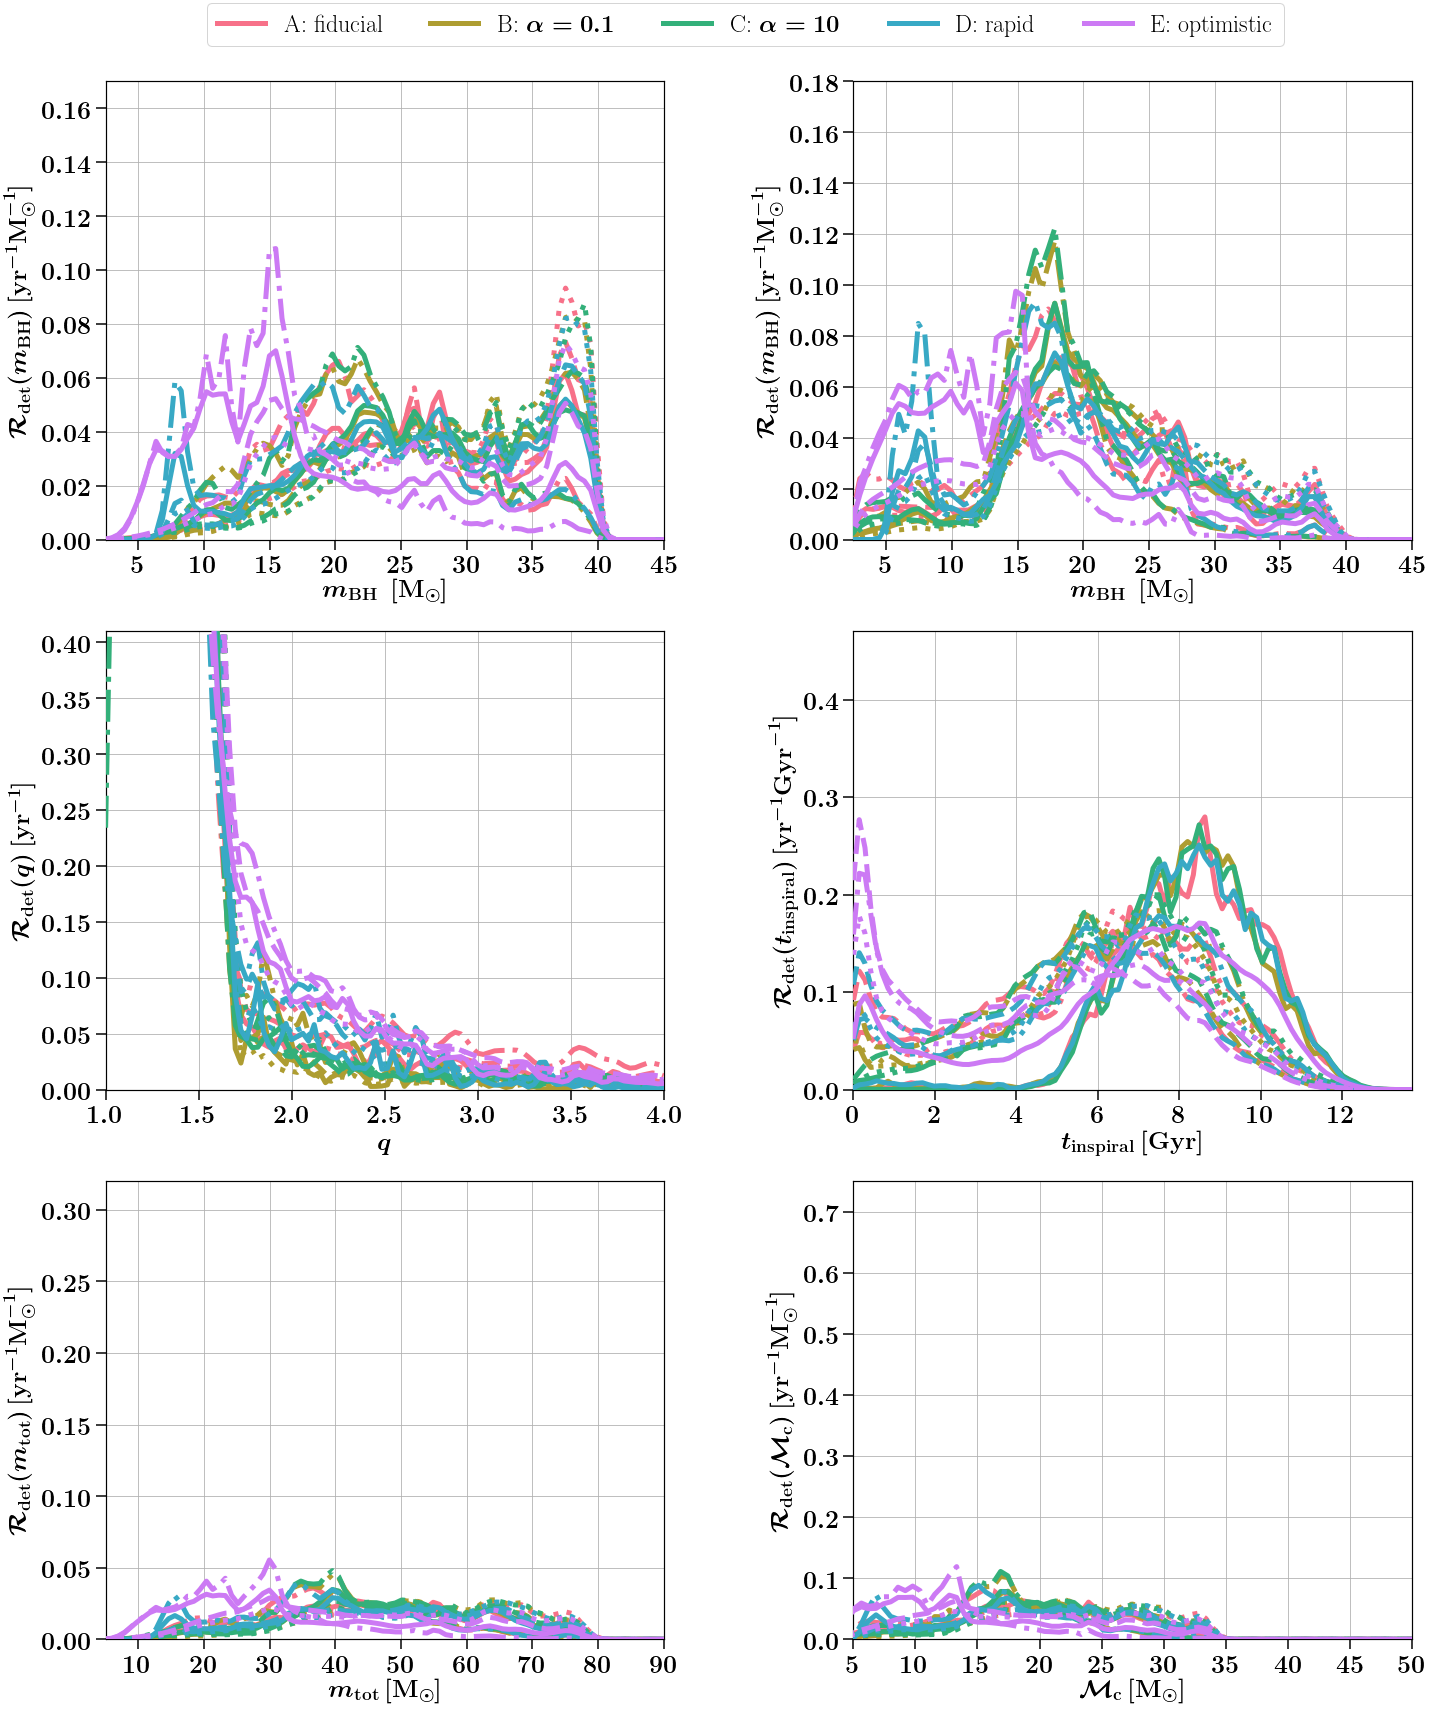

In [243]:
# Datalist = [Data_model_BBH_1] #, Data_model_BBH_2, Data_model_BBH_3]
# modelnameslist = [r'Fiducial'] #, r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
# rateslist = [rates_model_BBH_1, rates_model_BBH_2, rates_model_BBH_3]
# totalslist = [totals_model_BBH_A, totals_model_BBH_2, totals_model_BBH_3]
modelcolors = sns.color_palette("husl", 5) 


weightslist = [rates_model_BBH_A, rates_model_BBH_B, rates_model_BBH_C, rates_model_BBH_D, rates_model_BBH_E]
# labellist=modelnameslist
linewidth=3.5
ALPHA=0


f, ax= plt.subplots(ncols=2,nrows=3,figsize=(20,23), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2,2]})

labellist = [r'A: fiducial',r'B: $\alpha =0.1$',r'C: $\alpha=10$',r'D: rapid',r'E: optimistic',]
#general
Nbins= .06 #.05#50 #.1 #50


Datalist = [Data_model_BBH_A, Data_model_BBH_B, Data_model_BBH_C, Data_model_BBH_D, Data_model_BBH_E]

####### BH MASS 
xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MBH
    xvarlist.append(xvar)  


nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'

handles, labels=plotdesigndistributionModels(axe=ax[0,0], xvarlist=xvarlist, \
                                             weightslist=weightslist, bandwidth=Nbins,\
                                             xvarrange=[2.5,50],  labellist=labellist,\
                                             xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,45], ylim=[0,.17], indplot=0) 


# ####### NS MASS 

xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MNS
    xvarlist.append(xvar)  

# xvar = MNS
nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{BH}}$   $ \,  [\rm{M}_{\odot}]$ '

_,_=plotdesigndistributionModels(axe=ax[0,1], xvarlist=xvarlist, weightslist=weightslist,\
                                 bandwidth=Nbins, xvarrange=[1,50] ,\
                                 labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,45], ylim=[0,0.18], indplot=1) 




# ####### mass ratio
xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MBH/MNS
    xvarlist.append(xvar)  
# 
nameY = r'$ \mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
nameX = r'$q$'

_,_=plotdesigndistributionModels(axe=ax[1,0], xvarlist=xvarlist, weightslist=weightslist, bandwidth=Nbins, xvarrange=[1,4] ,labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,4], ylim=[0,.41], indplot=2) 

# ######## INSPIRAL TIME


xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
#     M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
#     MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = Data.COMPAS.tc / 1000
    xvarlist.append(xvar)  

nameY = r'$ \mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

_,_=plotdesigndistributionModels(axe=ax[1,1], xvarlist=xvarlist, weightslist=weightslist, bandwidth=Nbins, xvarrange=[0,14] ,labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[0,13.7], ylim=[0,0.47], indplot=3) 




# ####### mass total

xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MBH+MNS
    xvarlist.append(xvar)  

# xvar = MBH+MNS
nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistributionModels(axe=ax[2,0], xvarlist=xvarlist, weightslist=weightslist, bandwidth=Nbins, xvarrange=[5,100] ,labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[5,90], ylim=[0,0.32], indplot=4) 


# ####### mass chirp
xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = chirpmass(MBH, MNS)
    xvarlist.append(xvar)  




# xvar = chirpmass(MBH, MNS)
nameY = r'$ \mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistributionModels(axe=ax[2,1], xvarlist=xvarlist, weightslist=weightslist, bandwidth=Nbins, xvarrange=[1.5,60] ,labellist=labellist, xlabel=nameX, ylabel=nameY, \
                              xlim=[5,50], ylim=[0,0.75], indplot=5) 

# # ###########


# LEGEND
lgd = f.legend(handles, labels, fontsize=fs, ncol=5,\
         bbox_to_anchor=(.9, 1.04),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./ObservedDistributions_4MSSFR_models_BBH.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

plt.close()



# (axe, xvar, bandwidth,  xlabel, ylabel, xlim, ylim, indplot)






In [253]:
def plot2Ddistribution(axe, var, weight, nrbins,  rateslist, totalslist,  labellist, xlimlist, indplot):
    """ plot distribution of xvar for array of metallicities 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """    

    

    FIRSTlabel =0
    
    Nparam = len(var)

    
    
    for jj, param_x in enumerate(var):
#         print( 'ii = ', ii)
        
        for ii, param_y in enumerate(var):
#             print('jj = ', jj)
            
            
            if ii==jj:
                axe[ii,jj].hist(param_x, bins=nrbins, color='b', linewidth=5,\
                                weights=weight, histtype='step')
                ylabel='PDF'
                
                
            elif jj>ii:
                ax[ii,jj].set_axis_off()
                if FIRSTlabel ==0:
                    ax[ii,jj].text(0.1, 0.5, \
                                   s=MODELNAME, fontsize=fs+22,\
                                   rotation=0, verticalalignment='bottom', transform=ax[ii,jj].transAxes) 
                    FIRSTlabel=1
            # 2D HISTOGRAM
            else:
                print('ii,jj=', ii, jj)
                ylabel=labellist[ii]
                
                ax[ii,jj].hist2d(param_x, param_y, bins=nrbins, weights=weight, normed=True)
                
                # axes & labels 
                if xlimlist[ii]:
                    axe[ii,jj].set_ylim(xlimlist[ii])
            
            
            
            
            
            
            # FOR ALL SUB PLOTS 
            xlabel = labellist[jj]
            axe[ii,jj] == CV.layoutAxes(axe[ii,jj], nameX=xlabel, nameY=ylabel)
            axe[ii,jj].grid(True)
            
            if xlimlist[ii]:
                
                axe[ii,jj].set_xlim(xlimlist[ii])    
    

            
        
        



   
    

    
    if indplot==0: 
        handles, labels = axe[ii,jj].get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    
    
    return handles, labels

###################




    

('at model =', 0)
('ii,jj=', 1, 0)


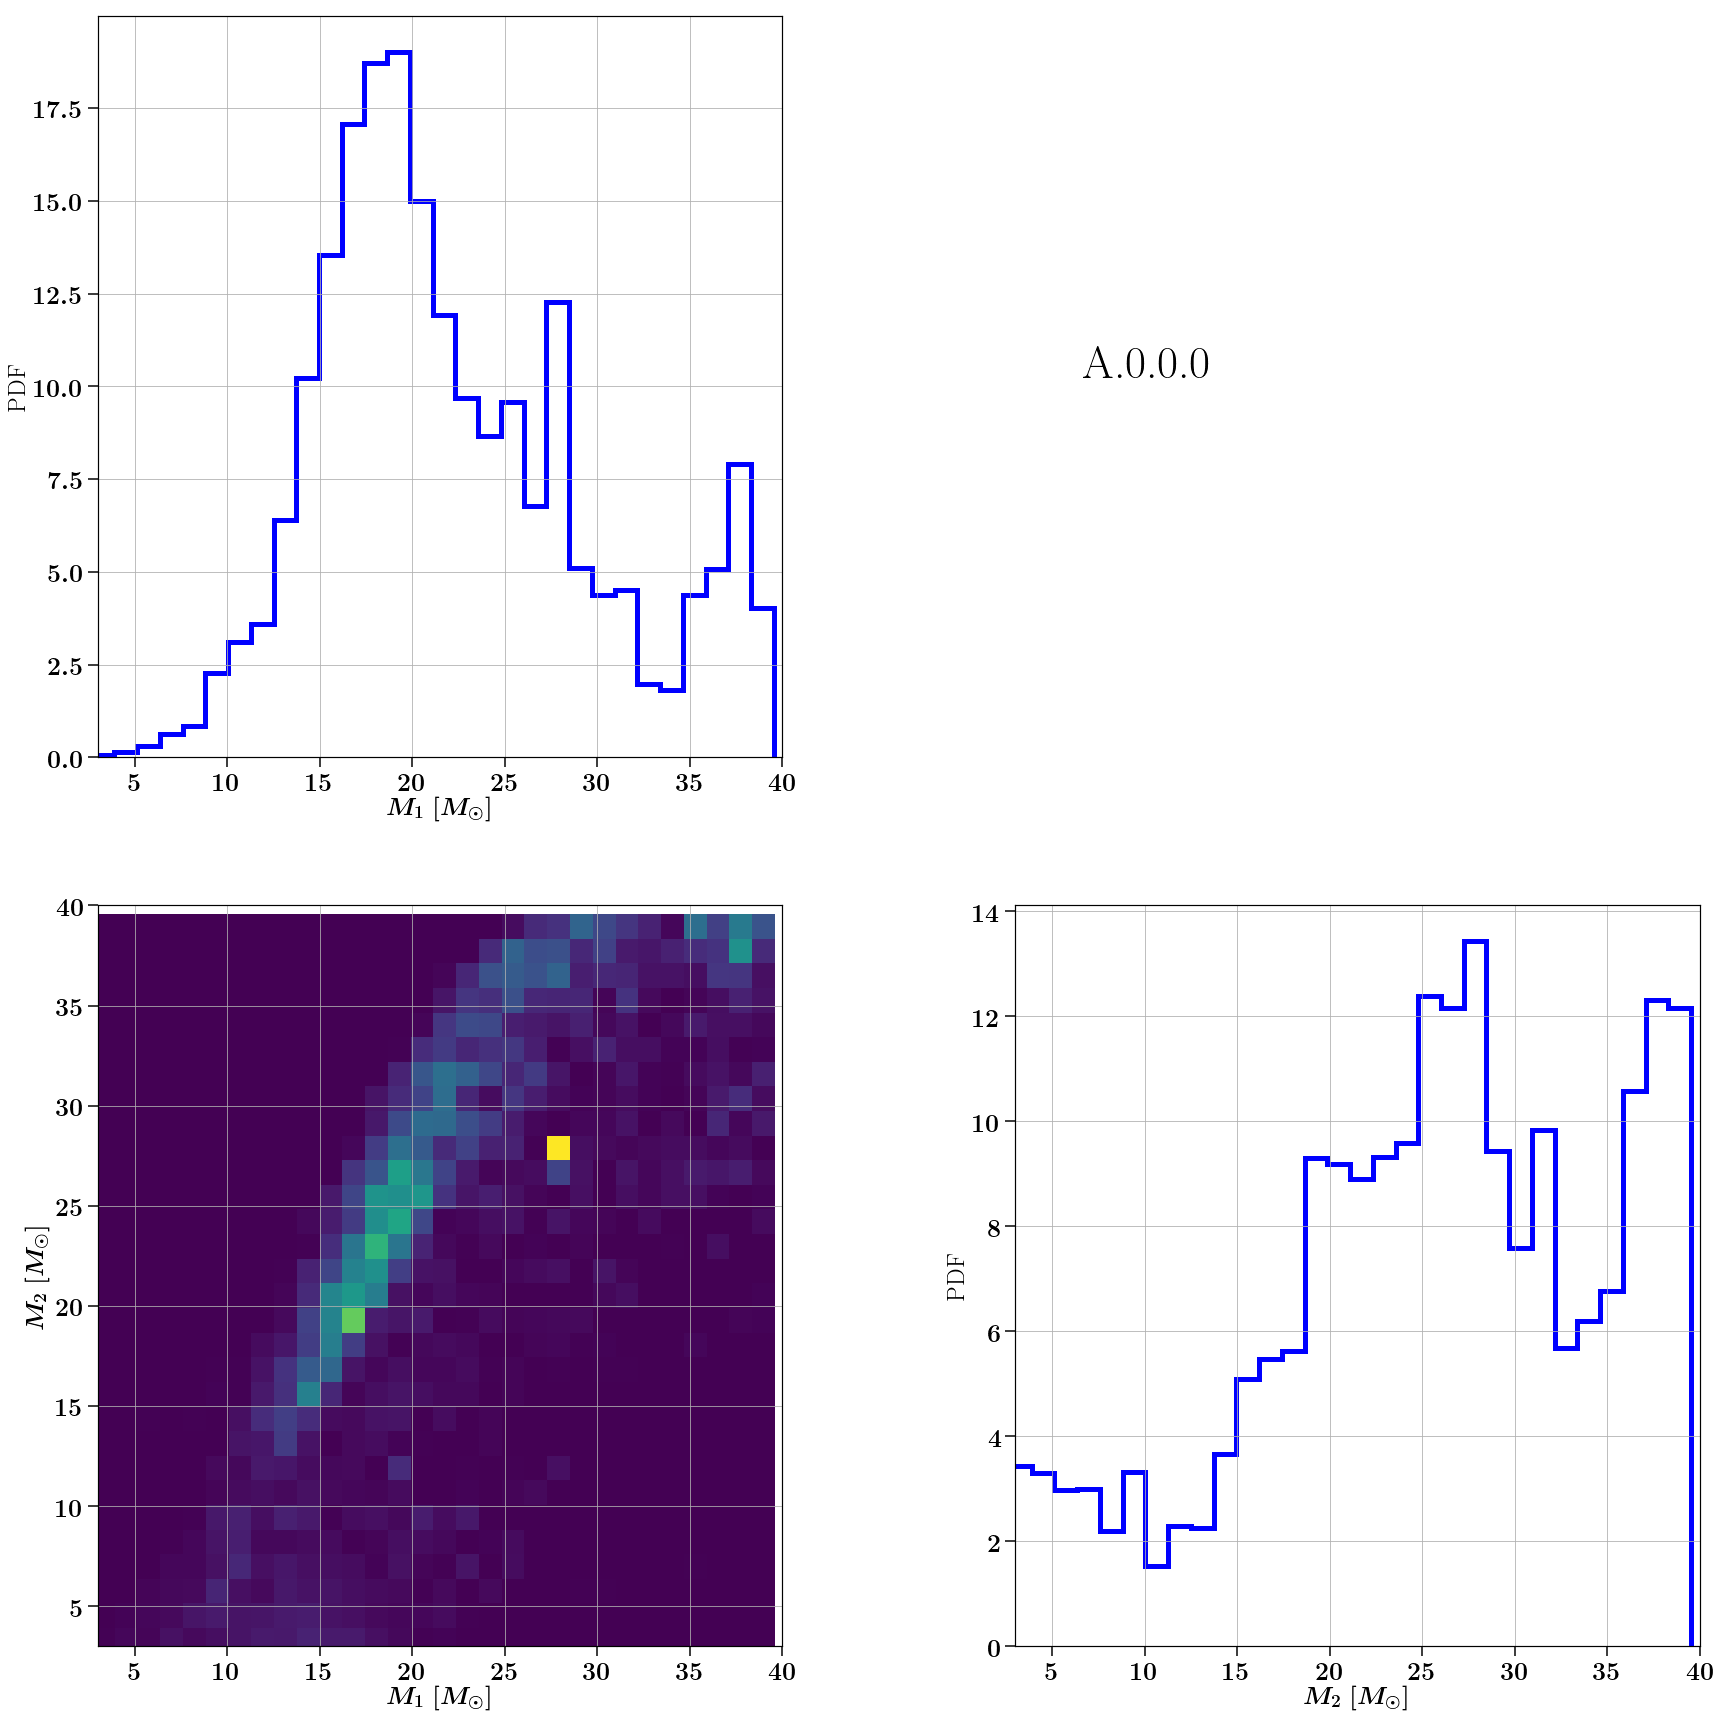

('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)
('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)
('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)
('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)
('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)


In [260]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
MSSFRlabels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']

modellabels = ['A', 'B', 'C', 'D', 'E']




# Datalist = [Data_model_BBH_1] #, Data_model_BBH_2, Data_model_BBH_3]
# modelnameslist = [r'Fiducial'] #, r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
# rateslist = [rates_model_BBH_1, rates_model_BBH_2, rates_model_BBH_3]
# totalslist = [totals_model_BBH_A, totals_model_BBH_2, totals_model_BBH_3]
modelcolors = sns.color_palette("husl", 5) 


weightslist = [rates_model_BBH_A, rates_model_BBH_B, rates_model_BBH_C, rates_model_BBH_D, rates_model_BBH_E]
# labellist=modelnameslist
linewidth=3.5
ALPHA=0




labellist = [r'A: fiducial',r'B: $\alpha =0.1$',r'C: $\alpha=10$',r'D: rapid',r'E: optimistic',]
#general
Nbins= .06 #.05#50 #.1 #50


Datalist = [Data_model_BBH_A, Data_model_BBH_B, Data_model_BBH_C, Data_model_BBH_D, Data_model_BBH_E]

####### BH MASS 
xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MBH
    xvarlist.append(xvar)  
    
    
    
    
    
for ind_m, model in enumerate(Datalist):
    Data = Datalist[ind_m]
    for ind_MSSFR, MSSFRlabel in enumerate(MSSFRlabels):
        MSSFRrate = weightslist[ind_m][ind_MSSFR]
        
        
        print('at model =', ind_MSSFR)
        Nbins = 30 

        labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$']


        f, ax= plt.subplots(ncols=2,nrows=2,figsize=(24,24), 
                          gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2]})


        weights = MSSFRrate
        var = [Data.COMPAS.mass1, Data.COMPAS.mass2]
        MODELNAME = modellabels[ind_m] + MSSFRlabels[ind_MSSFR]

        handles, labels =  plot2Ddistribution(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                              rateslist=None, totalslist=None,\
                                              labellist=labellist,\
                                              xlimlist=[[3,40],[3,40]], indplot=0)



        # plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
        #                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
        #                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




        # # # # LEGEND
        # # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
        # #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




        plt.tight_layout()
        plt.subplots_adjust(wspace=0.34, hspace=0.2)
        plt.savefig('./imagesBBH/BBH_TrianglePlot_2Dhist_model_'+ str(MODELNAME) +'.png', dpi=100, transparent=False,\
                   bbox_extra_artists=(lgd,), bbox_inches='tight')
        if (ind_m==0) & (ind_MSSFR==0):
            plt.show()
        plt.close()

In [265]:
filenames = []

for ind_m, model in enumerate(Datalist):
#     print(ind_m)
    for ind_MSSFR, MSSFRrate in enumerate(MSSFRlabels):
        MODELNAME = modellabels[ind_m] + MSSFRlabels[ind_MSSFR]
        filenames.append('BBH_TrianglePlot_2Dhist_model_'+ str(MODELNAME) +'.png')

print(filenames)
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('./imagesBBH/'+filename))
imageio.mimsave('./imagesBBH/BBH_MSSFR_and_MODELS_movie2Dhist.gif', images)

['BBH_TrianglePlot_2Dhist_model_A.0.0.0.png', 'BBH_TrianglePlot_2Dhist_model_A.1.1.1.png', 'BBH_TrianglePlot_2Dhist_model_A.2.1.1.png', 'BBH_TrianglePlot_2Dhist_model_A.1.1.3.png', 'BBH_TrianglePlot_2Dhist_model_B.0.0.0.png', 'BBH_TrianglePlot_2Dhist_model_B.1.1.1.png', 'BBH_TrianglePlot_2Dhist_model_B.2.1.1.png', 'BBH_TrianglePlot_2Dhist_model_B.1.1.3.png', 'BBH_TrianglePlot_2Dhist_model_C.0.0.0.png', 'BBH_TrianglePlot_2Dhist_model_C.1.1.1.png', 'BBH_TrianglePlot_2Dhist_model_C.2.1.1.png', 'BBH_TrianglePlot_2Dhist_model_C.1.1.3.png', 'BBH_TrianglePlot_2Dhist_model_D.0.0.0.png', 'BBH_TrianglePlot_2Dhist_model_D.1.1.1.png', 'BBH_TrianglePlot_2Dhist_model_D.2.1.1.png', 'BBH_TrianglePlot_2Dhist_model_D.1.1.3.png', 'BBH_TrianglePlot_2Dhist_model_E.0.0.0.png', 'BBH_TrianglePlot_2Dhist_model_E.1.1.1.png', 'BBH_TrianglePlot_2Dhist_model_E.2.1.1.png', 'BBH_TrianglePlot_2Dhist_model_E.1.1.3.png']


# SCATTER

In [13]:
# def plot2DdistributionScatter(axe, var, weight, nrbins,  rateslist, totalslist,  labellist, xlimlist, indplot):
#     """ plot distribution of xvar for array of metallicities 
#     input:
    
#     axe = the axis to plot it on
#     xvar= the array of data that you want to plot the kde of
#     bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
#     xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
#     xlabel, ylabel = x and y labels of the plot
#     xlim, ylim = xlim and ylim of the plot axis 
#     indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
#     you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
#     """    

    

#     FIRSTlabel =0
    
#     Nparam = len(var)

    
    
#     for jj, param_x in enumerate(var):
# #         print( 'ii = ', ii)
        
#         for ii, param_y in enumerate(var):
# #             print('jj = ', jj)
            
            
#             if ii==jj:
#                 axe[ii,jj].hist(param_x, bins=nrbins, color='b', linewidth=5,\
#                                 weights=weight, histtype='step')
#                 ylabel='PDF'
                
                
#             elif jj>ii:
#                 ax[ii,jj].set_axis_off()
#                 if FIRSTlabel ==0:
#                     ax[ii,jj].text(0.1, 0.5, \
#                                    s=MODELNAME, fontsize=fs+22,\
#                                    rotation=0, verticalalignment='bottom', transform=ax[ii,jj].transAxes) 
#                     FIRSTlabel=1
#             # 2D HISTOGRAM
#             else:
#                 print('ii,jj=', ii, jj)
#                 ylabel=labellist[ii]
                
#                 ax[ii,jj].scatter(param_x, param_y, s=weight*50, color=modelcolors[ind_m])
# #                 hist2d(param_x, param_y, bins=nrbins, weights=weight, normed=True)
                
#                 # axes & labels 
#                 if xlimlist[ii]:
#                     axe[ii,jj].set_ylim(xlimlist[ii])
            
            
            
            
            
            
#             # FOR ALL SUB PLOTS 
#             xlabel = labellist[jj]
#             axe[ii,jj] == CV.layoutAxes(axe[ii,jj], nameX=xlabel, nameY=ylabel)
#             axe[ii,jj].grid(True)
            
#             if xlimlist[ii]:
                
#                 axe[ii,jj].set_xlim(xlimlist[ii])    
    

            
        
        



   
    

    
#     if indplot==0: 
#         handles, labels = axe[ii,jj].get_legend_handles_labels()
#     else:
#         handles, labels = None, None
        
    
    
#     return handles, labels

# ###################




    

In [118]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
MSSFRlabels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']

modellabels = ['A', 'B', 'C', 'D', 'E']




# Datalist = [Data_model_BBH_1] #, Data_model_BBH_2, Data_model_BBH_3]
# modelnameslist = [r'Fiducial'] #, r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
# rateslist = [rates_model_BBH_1, rates_model_BBH_2, rates_model_BBH_3]
# totalslist = [totals_model_BBH_A, totals_model_BBH_2, totals_model_BBH_3]
modelcolors = sns.color_palette("husl", 5) 


weightslist = [rates_model_BBH_A, rates_model_BBH_B, rates_model_BBH_C, rates_model_BBH_D, rates_model_BBH_E]
# labellist=modelnameslist
linewidth=3.5
ALPHA=0




labellist = [r'A: fiducial',r'B: $\alpha =0.1$',r'C: $\alpha=10$',r'D: rapid',r'E: optimistic',]
#general
Nbins= .06 #.05#50 #.1 #50


Datalist = [Data_model_BBH_A, Data_model_BBH_B, Data_model_BBH_C, Data_model_BBH_D, Data_model_BBH_E]

####### BH MASS 
xvarlist = []
for ind_m, models in enumerate(Datalist):
    Data = Datalist[ind_m]
    
    M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
    MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

    xvar = MBH
    xvarlist.append(xvar)  
    
    
    
    
    
for ind_m, model in enumerate(Datalist):
    Data = Datalist[ind_m]
    for ind_MSSFR, MSSFRlabel in enumerate(MSSFRlabels):
        MSSFRrate = weightslist[ind_m][ind_MSSFR]
        
        
        print('at model =', ind_MSSFR)
        Nbins = 30 

        labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$']


        f, ax= plt.subplots(ncols=2,nrows=2,figsize=(24,24), 
                          gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2]})


        weights = MSSFRrate
        var = [Data.COMPAS.mass1, Data.COMPAS.mass2]
        MODELNAME = modellabels[ind_m] + MSSFRlabels[ind_MSSFR]

        handles, labels =  plot2DdistributionScatter(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                              rateslist=None, totalslist=None,\
                                              labellist=labellist,\
                                              xlimlist=[[3,40],[3,40]], indplot=0)



        # plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
        #                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
        #                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




        # # # # LEGEND
        # # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
        # #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




        plt.tight_layout()
        plt.subplots_adjust(wspace=0.34, hspace=0.2)
        plt.savefig('./imagesBBH/BBH_TrianglePlot_scatter_model_'+ str(MODELNAME) +'.png', dpi=100, transparent=False,\
                   bbox_extra_artists=(lgd,), bbox_inches='tight')
#         plt.show()
        plt.close()

('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)
('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)
('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)
('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)
('at model =', 0)
('ii,jj=', 1, 0)
('at model =', 1)
('ii,jj=', 1, 0)
('at model =', 2)
('ii,jj=', 1, 0)
('at model =', 3)
('ii,jj=', 1, 0)


In [266]:
filenames = []

for ind_m, model in enumerate(Datalist):
    for ind_MSSFR, MSSFRrate in enumerate(MSSFRlabels):
        MODELNAME = modellabels[ind_m] + MSSFRlabels[ind_MSSFR]
        filenames.append('BBH_TrianglePlot_scatter_model_'+ str(MODELNAME) +'.png')


import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('./imagesBBH/'+filename))
imageio.mimsave('./imagesBBH/BBH_MSSFR_and_MODELS_movieScatter.gif', images)

In [ ]:
## RESULTS 

In [36]:
def plot2DdistributionScatter(axe, var, weight, nrbins,  rateslist, totalslist,  labellist, xlimlist, indplot):
    """ plot distribution of xvar for array of metallicities 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """    

    
    MASKING = True
    FIRSTlabel =0
    
    Nparam = len(var)

    
    
    for jj, param_x in enumerate(var):
#         print( 'ii = ', ii)
        
        for ii, param_y in enumerate(var):
#             print('jj = ', jj)
            
            
            if ii==jj:
                axe[ii,jj].hist(param_x, bins=nrbins, color='b', linewidth=5,\
                                weights=weight, histtype='step')
                ylabel='PDF'
                
                if xlimlist[ii]:
                    axe[ii,jj].set_xlim(xlimlist[jj]) 
                    
            elif jj>ii:
                ax[ii,jj].set_axis_off()
                if FIRSTlabel ==0:
                    ax[ii,jj].text(0.1, 0.5, \
                                   s=MODELNAME, fontsize=fs+22,\
                                   rotation=0, verticalalignment='bottom', transform=ax[ii,jj].transAxes) 
                    FIRSTlabel=1
            # 2D HISTOGRAM
            else:
                print('ii,jj=', ii, jj)
                ylabel=labellist[ii]
                if MASKING==True:
                    
                    M1, M2 = obtainM1BHandM2BHassymetric(m1=var[0], m2=var[1])
                    massratio = M2/M1
                    
                    maskM1M2 = ((M1<=34.7)&(M1>=24.4)) & ((M2<=10.1)&(M2>=7.4)) & (massratio<=0.41)
                    ax[ii,jj].scatter(param_x, param_y, s=weight*50, color='gray')
                    ax[ii,jj].scatter(param_x[maskM1M2], param_y[maskM1M2], s=weight[maskM1M2]*500,\
                                      color=modelcolors[0], zorder=1000)
                else:
                    ax[ii,jj].scatter(param_x, param_y, s=weight*50, color=modelcolors[ind_m])
#                 hist2d(param_x, param_y, bins=nrbins, weights=weight, normed=True)
                
                # axes & labels 
                if xlimlist[ii]:
                    axe[ii,jj].set_ylim(xlimlist[ii])
                if xlimlist[jj]:
                    axe[ii,jj].set_xlim(xlimlist[jj])
            
            
            
            
            
            
            # FOR ALL SUB PLOTS 
            xlabel = labellist[jj]
            axe[ii,jj] == CV.layoutAxes(axe[ii,jj], nameX=xlabel, nameY=ylabel)
            axe[ii,jj].grid(True)
            
  
    

            
        
        



   
    

    
    if indplot==0: 
        handles, labels = axe[ii,jj].get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    
    
    return handles, labels

###################




    

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


PerSystemPerRedshift_ratesIntrinsic_z0_BBH_E = []

In [ ]:
def plot_q_CDF():



In [ ]:
# weightslist = [PerSystemPerRedshift_ratesIntrinsic_z0_BBH_A, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_B,\
#                PerSystemPerRedshift_ratesIntrinsic_z0_BBH_C, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_D, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_E, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_F, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_G, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_H]


('at model: ', 'A', '.0.0.0')
211.88777397922095
('Rate 0 =', 211.88777397922095)
('Rate 0 Intrinsic =', 25.29534472544685)
('Rate 1 =', 8.572806329999155)
('Rate 2 =', 0.2287828477304003)
()
('Rate 1 fraction =', 0.040459183505509186)
('Rate 2 fraction =', 0.0010797359537735112)
non 0 LABEL
('at model: ', 'B', '.0.0.0')
165.98137224510154
('Rate 0 =', 165.98137224510154)
('Rate 0 Intrinsic =', 17.592653385152424)
('Rate 1 =', 1.5188464799343118)
('Rate 2 =', 0.09107947980281987)
()
('Rate 1 fraction =', 0.00915070443984196)
('Rate 2 fraction =', 0.000548733141381218)
non 0 LABEL
('at model: ', 'C', '.0.0.0')
163.67473170907257
('Rate 0 =', 163.67473170907257)
('Rate 0 Intrinsic =', 19.359564921901907)
('Rate 1 =', 3.405910706086817)
('Rate 2 =', 0.27592522351344834)
()
('Rate 1 fraction =', 0.02080901963621808)
('Rate 2 fraction =', 0.0016858144237187325)
non 0 LABEL
('at model: ', 'D', '.0.0.0')
216.15089074781977
('Rate 0 =', 216.15089074781977)
('Rate 0 Intrinsic =', 27.74655979834

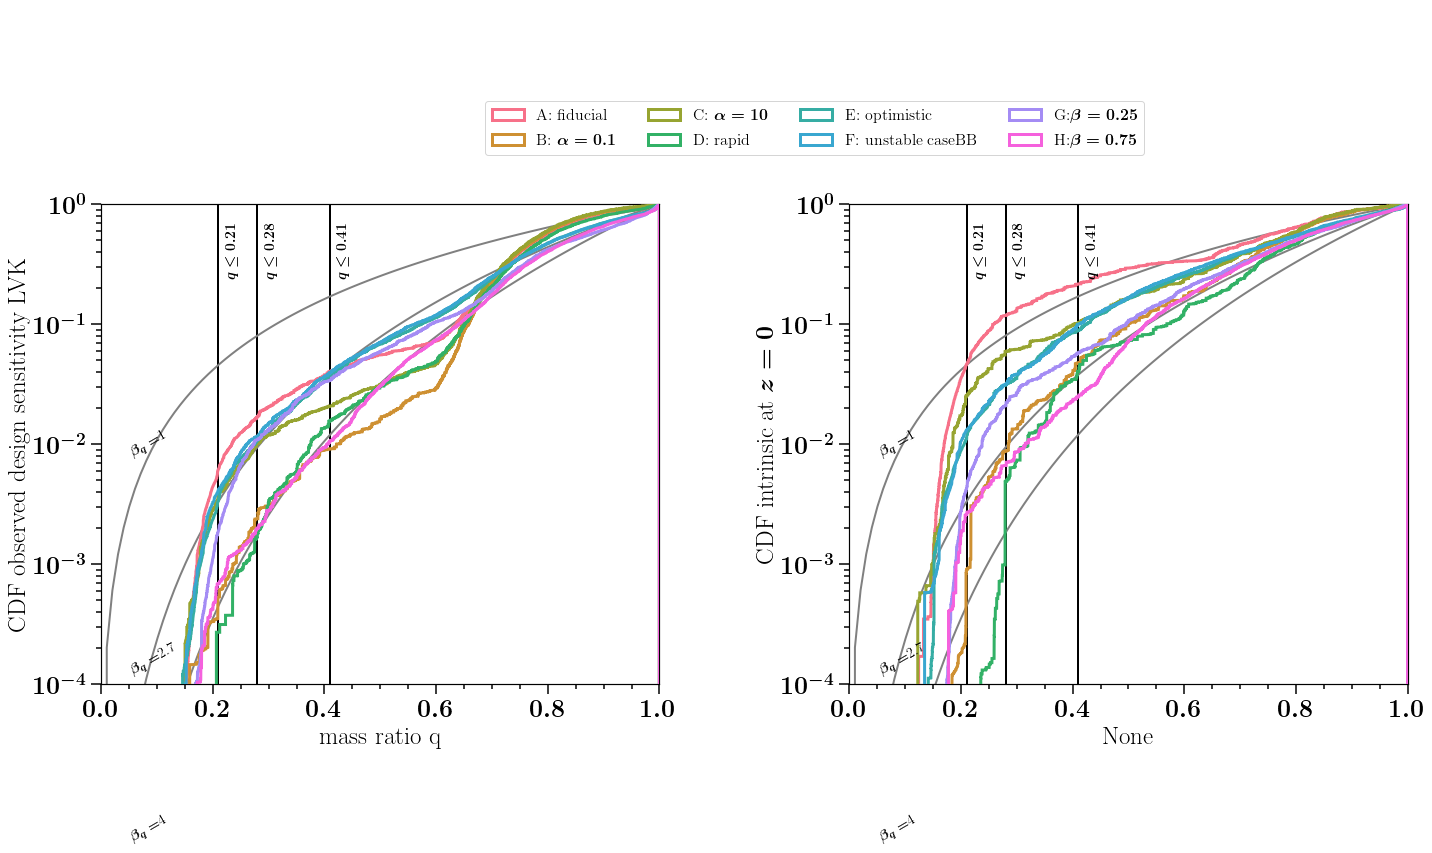

In [124]:

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
MSSFRlabels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']

modellabels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']


modelcolors = sns.color_palette("husl", len(modellabels)) 


weightslist = [rates_model_BBH_A, rates_model_BBH_B,\
               rates_model_BBH_C, rates_model_BBH_D, rates_model_BBH_E, rates_model_BBH_F, rates_model_BBH_G, rates_model_BBH_H]


weightslistIntrinsic_z0 = [PerSystemPerRedshift_ratesIntrinsic_z0_BBH_A, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_B,\
               PerSystemPerRedshift_ratesIntrinsic_z0_BBH_C, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_D,\
                           PerSystemPerRedshift_ratesIntrinsic_z0_BBH_E, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_F,\
                           PerSystemPerRedshift_ratesIntrinsic_z0_BBH_G, PerSystemPerRedshift_ratesIntrinsic_z0_BBH_H]


linewidth=3.5
ALPHA=0




labellist = [r'A: fiducial',r'B: $\alpha =0.1$',\
             r'C: $\alpha=10$',r'D: rapid',r'E: optimistic',r'F: unstable caseBB',r'G:$\beta=0.25$',r'H:$\beta=0.75$' ]
#general
Nbins= .06 #.05#50 #.1 #50


Datalist = [Data_model_BBH_A, Data_model_BBH_B, Data_model_BBH_C, Data_model_BBH_D, Data_model_BBH_E,  Data_model_BBH_F,  Data_model_BBH_G,  Data_model_BBH_H]

# ####### BH MASS 
# xvarlist = []
# for ind_m, models in enumerate(Datalist[0]):
#     Data = Datalist[ind_m]
    
#     M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
#     MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

#     xvar = MBH
#     xvarlist.append(xvar)  
    
    
f, axe= plt.subplots(ncols=2,nrows=1,figsize=(20,8), 
                  gridspec_kw={"width_ratios":1.5*np.ones(2), "height_ratios":2*np.ones(1)})


# Datalist = [Data_model_BBH_A]
# MSSFRlabels =['.0.0.0']
xlabel='mass ratio q'
ylabel='CDF observed design sensitivity LVK'
allhandles, alllabels = [], []
xlabel0=None
ylabel0=r'CDF intrinsic at $z=0$'
MSSFRlabels     = ['.0.0.0']
for ind_m, model in enumerate(Datalist):
    Data = Datalist[ind_m]
    for ind_MSSFR, MSSFRlabel in enumerate(MSSFRlabels):
        MSSFRrate = weightslist[ind_m][ind_MSSFR]
        weights = MSSFRrate

        MSSFRrateIntrinsic = weightslistIntrinsic_z0[ind_m][ind_MSSFR]
        MSSFRrateIntrinsic = MSSFRrateIntrinsic[0]

        print('at model: ', modellabels[ind_m], MSSFRlabels[ind_MSSFR])
        Nbins = 30 



        M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
        MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
        xvar_q = MNS/MBH



        print(np.sum(MSSFRrate))
        maskq0_4 = xvar_q <=0.41
        maskM1M2 = ((M1<=34.7)&(M1>=24.4)) & ((M2<=10.1)&(M2>=7.4))

        Pdays = convert_a_to_P_circular(separation=Data.COMPAS.separationDCOFormation*u.AU,\
                                        M1=M1*u.Msun, M2=M2*u.Msun)

        Pdays = Pdays.to(u.day)
        Pdays = Pdays.value

        print('Rate 0 =',np.sum(MSSFRrate))
        print('Rate 0 Intrinsic =',np.sum(MSSFRrateIntrinsic) )
        print('Rate 1 =',np.sum(MSSFRrate[maskq0_4]))
        print('Rate 2 =',np.sum(MSSFRrate[maskM1M2]))
        print()
        print('Rate 1 fraction =',np.sum(MSSFRrate[maskq0_4])/np.sum(MSSFRrate))
        print('Rate 2 fraction =',np.sum(MSSFRrate[maskM1M2])/np.sum(MSSFRrate))
        var = [Data.COMPAS.mass1, Data.COMPAS.mass2, xvar_q,\
               np.log10(Pdays),  np.log10(Data.COMPAS.tc),\
               np.log10((Data.COMPAS.metallicitySystems/0.0142))         ]
        MODELNAME = modellabels[ind_m] + MSSFRlabels[ind_MSSFR]


        if ind_MSSFR==0:
            print('non 0 LABEL')
            LABEL = labellist[ind_m]
        else:
            LABEL = None



        axe[1].hist(xvar_q, density=True, bins=len(xvar_q), cumulative=True, label=LABEL,
     histtype='step', alpha=1, color=modelcolors[ind_m], linewidth=3,\
         linestyle=linestyles[ind_MSSFR], zorder=10, weights=MSSFRrateIntrinsic)                


        axe[0].hist(xvar_q, density=True, bins=len(xvar_q), cumulative=True, label=None,
     histtype='step', alpha=1, color=modelcolors[ind_m], linewidth=3,\
         linestyle=linestyles[ind_MSSFR], zorder=10, weights=MSSFRrate)  

        # plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
        #                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
        #                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   



        if (ind_MSSFR==0):
#             print('HANDLES')
            HANDLES, LABELS =axe[1].get_legend_handles_labels()


        # # # # LEGEND
        # # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
        # #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')



        
axe[0] == CV.layoutAxes(axe[0], nameX=xlabel, nameY=ylabel)
axe[1] == CV.layoutAxes(axe[1], nameX=xlabel0, nameY=ylabel0)

# axe.grid(True)
# axe.xaxis.grid(True, which='minor')
for ax in [axe[0], axe[1]]:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_yscale('log')
    ax.set_xlim(0,1)
    ax.set_ylim(0.0001,1)


    for ind_q, qq in enumerate([0.21, 0.28, 0.41]):
        xx = np.ones(100)*qq
        yy = np.linspace(0.00001,1,len(xx))
        ax.plot(xx, yy, c='k', lw=2)
        ax.text(qq+0.01, 0.94, s=r'$q\leq %s$'%qq,\
                 horizontalalignment='left',\
                 transform=ax.transAxes, fontsize=14, rotation=90, zorder=10000)


        
        
    x_beta = np.linspace(0,1, 100)
    for ind_beta, beta in enumerate([1, 2.7, 4]):

        y_beta = x_beta**beta

    #     mask_m2Toolow = 



        y_beta = (y_beta / np.sum(y_beta)) # normalize to 1
        ax.plot(x_beta, np.cumsum(y_beta), lw=2, c='gray')  
        ax.text(0.05,np.cumsum(y_beta)[8] , s=r'$\beta_q=$%s'%beta, fontsize=14,\
         rotation=30, verticalalignment='bottom', zorder=10000)            

lgd = f.legend(HANDLES, LABELS, fontsize=fs-8, ncol=4,\
         bbox_to_anchor=(.8, 1.32),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./imagesBBH/BBH_CDF_q_models_singleMSSFR_9.pdf', transparent=False,\
                   bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

In [115]:

print(HANDLES, LABELS)

([], [])


[[array([0.        , 0.        , 0.        , ..., 0.00018335, 0.00010797,
       0.00115616]), array([1.16225437e-02, 6.37316639e-03, 4.51187250e-04, ...,
       6.52550762e-05, 1.10913435e-04, 4.33730528e-05]), array([1.07940929e-02, 5.65902704e-03, 4.51692530e-04, ...,
       5.47432148e-05, 1.02405673e-04, 3.92034465e-05]), array([4.68109255e-05, 2.30795892e-05, 1.96220357e-06, ...,
       2.17426737e-04, 1.19140002e-04, 1.54823646e-03])], [array([0.00000000e+00, 0.00000000e+00, 3.66400484e-13, ...,
       9.34230467e-04, 7.54020388e-05, 3.38171392e-04]), array([4.07669446e-03, 6.33624591e-03, 7.90876651e-02, ...,
       4.05169683e-06, 7.58184889e-05, 6.83605451e-05]), array([3.55238598e-03, 5.60900926e-03, 1.11251002e-01, ...,
       3.78649951e-06, 6.96205891e-05, 5.84194048e-05]), array([1.37915781e-05, 2.26208626e-05, 2.86059850e-04, ...,
       1.30220224e-03, 8.33175852e-05, 4.16270117e-04])], [array([0.00000000e+00, 0.00000000e+00, 6.17704322e-13, ...,
       1.52579080e-03,

('at model =', 0)
211.5440918807033
('Rate 0 =', 211.5440918807033)
('Rate 1 =', 8.558156421052615)
('Rate 2 =', 0.22833656676593883)
()
('Rate 1 fraction =', 0.040455662670450955)
('Rate 2 fraction =', 0.0010793804957441467)
('ii,jj=', 1, 0)
('ii,jj=', 2, 0)
('ii,jj=', 3, 0)
('ii,jj=', 4, 0)
('ii,jj=', 5, 0)
('ii,jj=', 2, 1)
('ii,jj=', 3, 1)
('ii,jj=', 4, 1)
('ii,jj=', 5, 1)
('ii,jj=', 3, 2)
('ii,jj=', 4, 2)
('ii,jj=', 5, 2)
('ii,jj=', 4, 3)
('ii,jj=', 5, 3)
('ii,jj=', 5, 4)


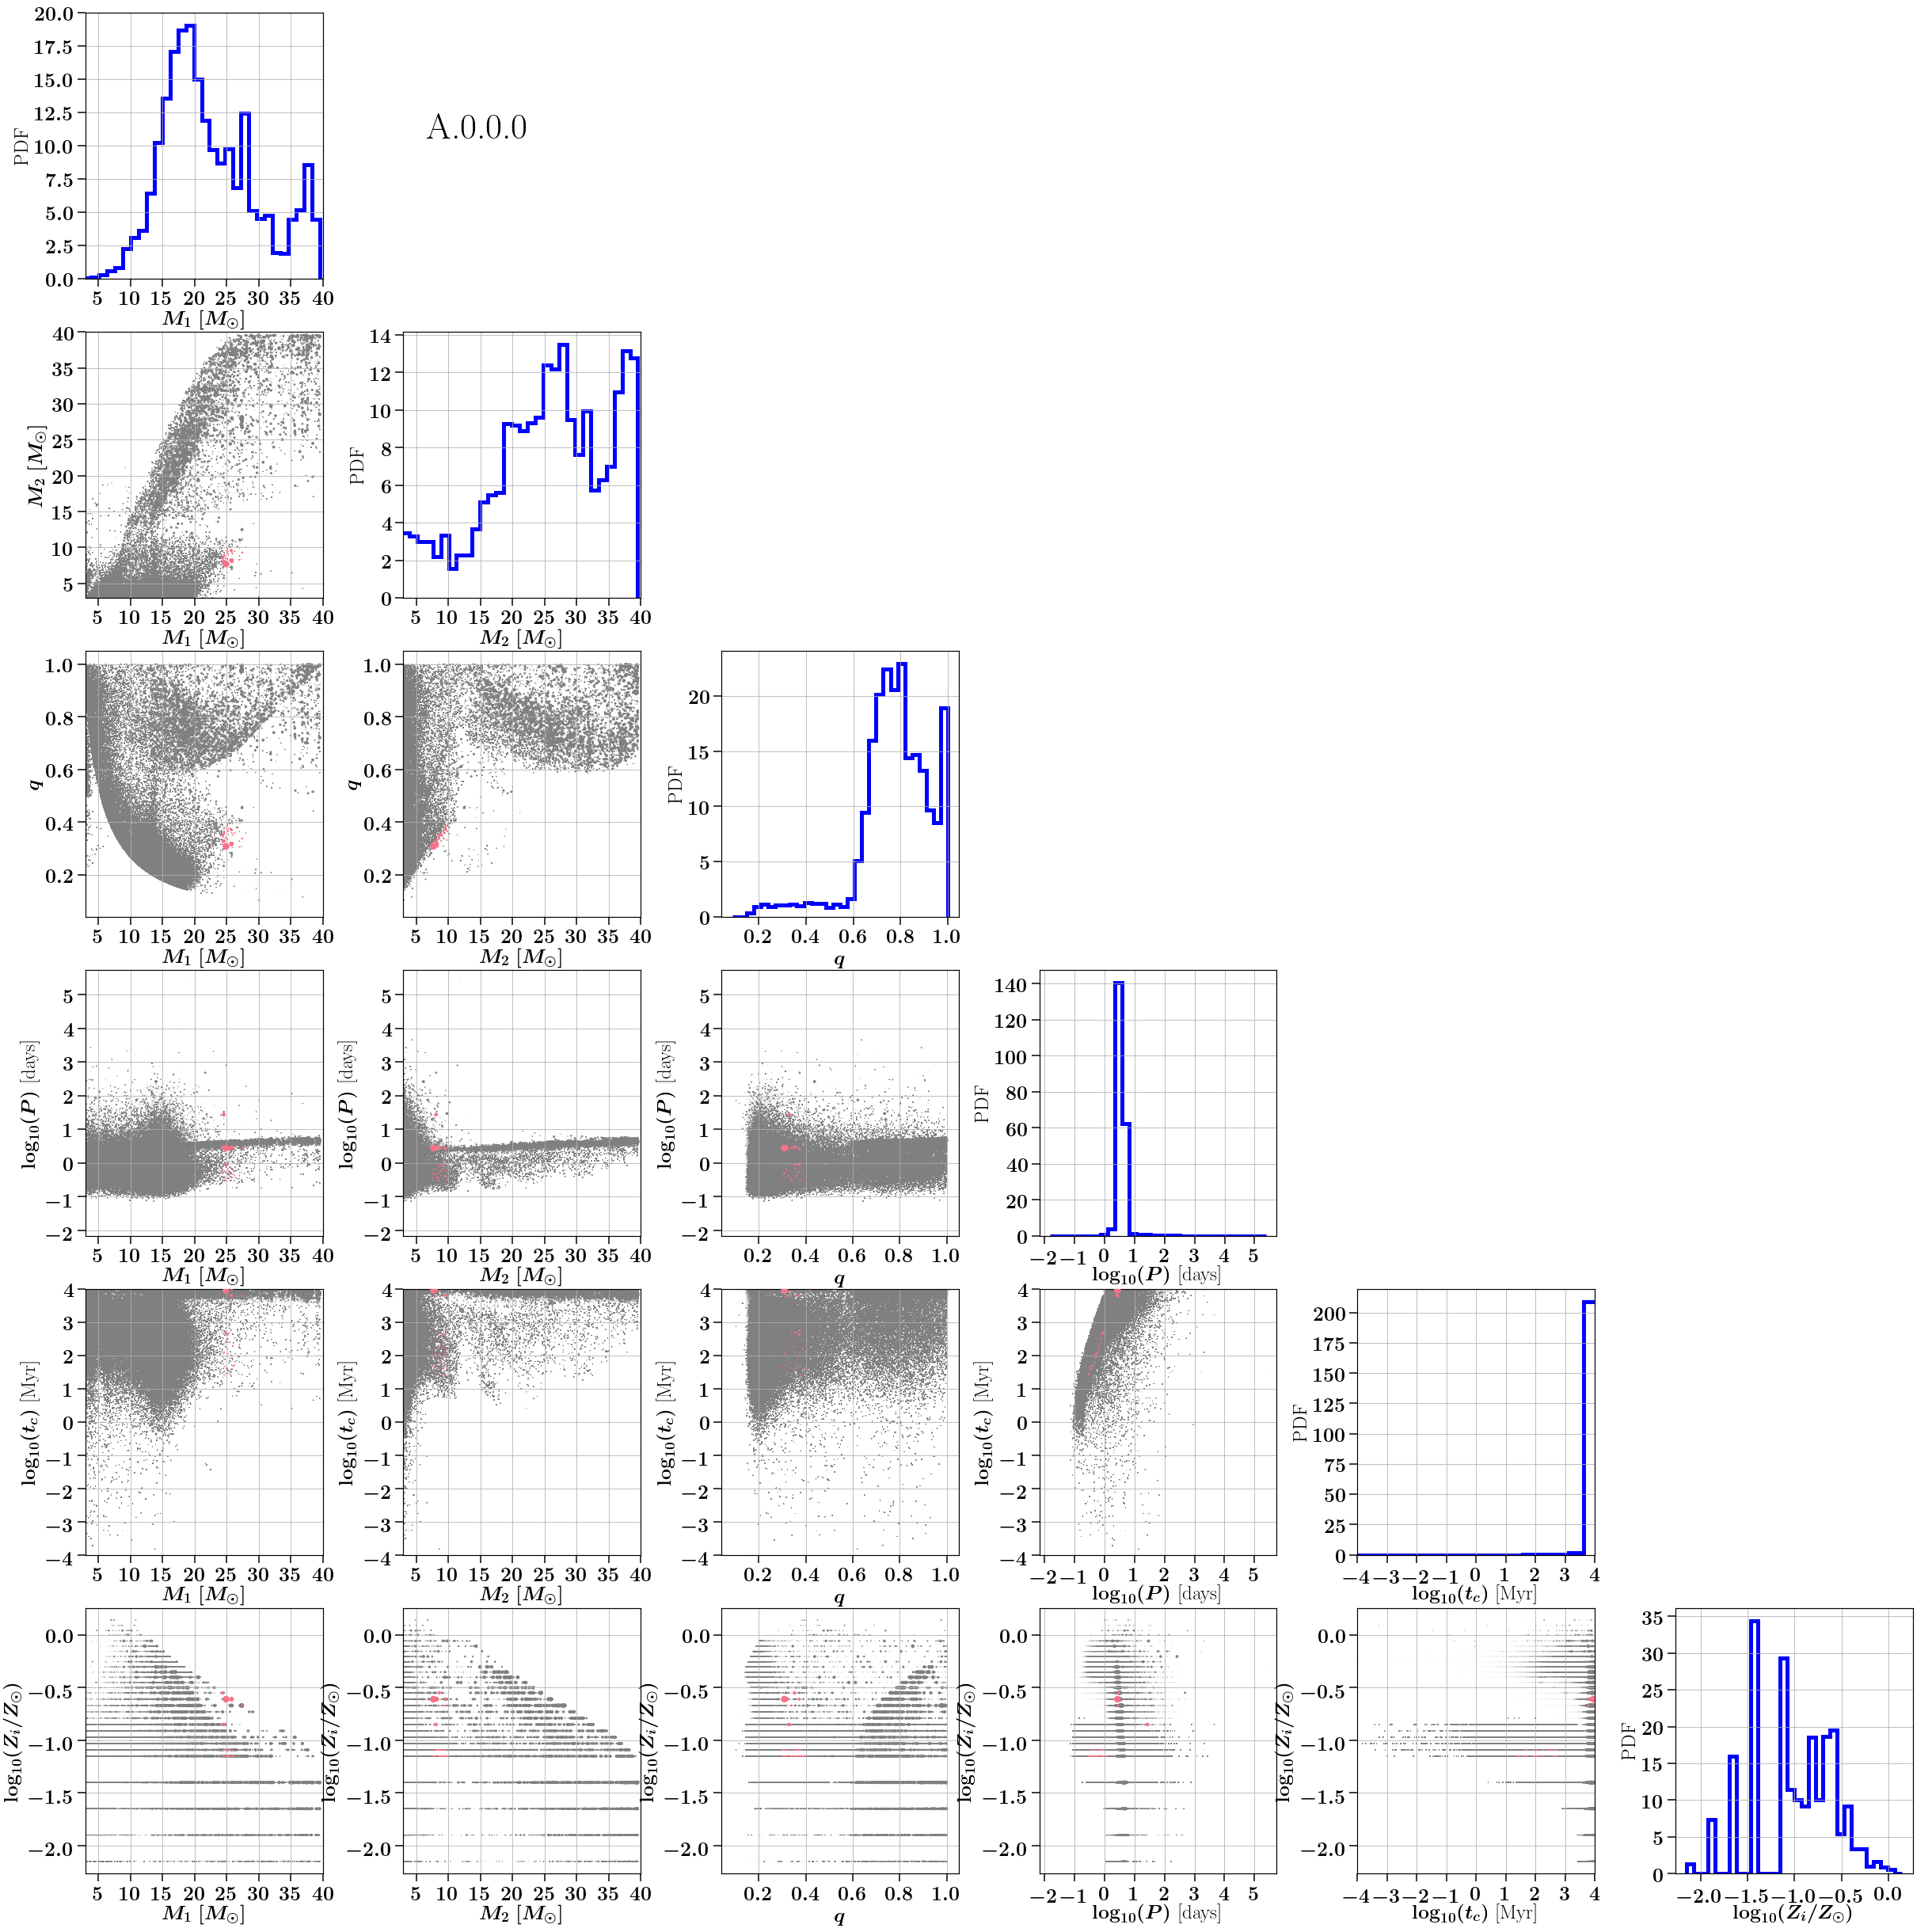

In [37]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
MSSFRlabels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']

modellabels = ['A', 'B', 'C', 'D', 'E']


modelcolors = sns.color_palette("husl", 5) 


weightslist = [rates_model_BBH_A, rates_model_BBH_B, rates_model_BBH_C, rates_model_BBH_D, rates_model_BBH_E]
linewidth=3.5
ALPHA=0




labellist = [r'A: fiducial',r'B: $\alpha =0.1$',r'C: $\alpha=10$',r'D: rapid',r'E: optimistic',]
#general
Nbins= .06 #.05#50 #.1 #50


Datalist = [Data_model_BBH_A, Data_model_BBH_B, Data_model_BBH_C, Data_model_BBH_D, Data_model_BBH_E]

# ####### BH MASS 
# xvarlist = []
# for ind_m, models in enumerate(Datalist[0]):
#     Data = Datalist[ind_m]
    
#     M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
#     MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

#     xvar = MBH
#     xvarlist.append(xvar)  
    
    
    
Datalist = [Data_model_BBH_A]
MSSFRlabels =['.0.0.0']
    
for ind_m, model in enumerate(Datalist):
    Data = Datalist[ind_m]
    for ind_MSSFR, MSSFRlabel in enumerate(MSSFRlabels):
        MSSFRrate = weightslist[ind_m][ind_MSSFR]
        
        
        print('at model =', ind_MSSFR)
        Nbins = 30 

        labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$',\
                   r'$q $', r'$\log_{10}(P) $ [days]', r'$ \log_{10}(t_c) $ [Myr]',\
                    r'$\log_{10}(Z_i/Z_{\odot}) $']


        f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(34,34), 
                          gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})
        
        M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
        MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
        xvar_q = MNS/MBH

        weights = MSSFRrate
        
        print(np.sum(MSSFRrate))
        maskq0_4 = xvar_q <=0.41
        maskM1M2 = ((M1<=34.7)&(M1>=24.4)) & ((M2<=10.1)&(M2>=7.4))
        
        Pdays = convert_a_to_P_circular(separation=Data.COMPAS.separationDCOFormation*u.AU,\
                                        M1=M1*u.Msun, M2=M2*u.Msun)
      
        Pdays = Pdays.to(u.day)
        Pdays = Pdays.value
        
        print('Rate 0 =',np.sum(MSSFRrate))
        print('Rate 1 =',np.sum(MSSFRrate[maskq0_4]))
        print('Rate 2 =',np.sum(MSSFRrate[maskM1M2]))
        print()
        print('Rate 1 fraction =',np.sum(MSSFRrate[maskq0_4])/np.sum(MSSFRrate))
        print('Rate 2 fraction =',np.sum(MSSFRrate[maskM1M2])/np.sum(MSSFRrate))
        var = [Data.COMPAS.mass1, Data.COMPAS.mass2, xvar_q,\
               np.log10(Pdays),  np.log10(Data.COMPAS.tc),\
               np.log10((Data.COMPAS.metallicitySystems/0.0142))         ]
        MODELNAME = modellabels[ind_m] + MSSFRlabels[ind_MSSFR]

        handles, labels =  plot2DdistributionScatter(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                              rateslist=None, totalslist=None,\
                                              labellist=labellist,\
                                              xlimlist=[[3,40],[3,40], None, None, [-4,4], None], indplot=0)



        # plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
        #                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
        #                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




        # # # # LEGEND
        # # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
        # #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




        plt.tight_layout()
        plt.subplots_adjust(wspace=0.34, hspace=0.2)
        plt.savefig('./imagesBBH/BBH_TrianglePlot_scatter_maskGW190412_'+ str(MODELNAME) +'_bigPlot.png', dpi=100, transparent=False)#,\
#                    bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()
        plt.close()

In [32]:



Pdays = convert_a_to_P_circular(separation=1*u.Rsun, M1=10*u.Msun, M2=1*u.Msun)
      
print(Pdays.to(u.day))

0.034925848944 d


In [119]:
method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Strolger et al. (2004)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Panter et al. (2004) Single' , 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
MSSFRlabels     = ['.0.0.0'                  , '.1.1.1'                    , '.2.1.1'                     , '.1.1.3']

modellabels = ['A', 'B', 'C', 'D', 'E']


modelcolors = sns.color_palette("husl", 5) 


weightslist = [rates_model_BBH_A, rates_model_BBH_B, rates_model_BBH_C, rates_model_BBH_D, rates_model_BBH_E]
linewidth=3.5
ALPHA=0




labellist = [r'A: fiducial',r'B: $\alpha =0.1$',r'C: $\alpha=10$',r'D: rapid',r'E: optimistic',]
#general
Nbins= .06 #.05#50 #.1 #50


Datalist = [Data_model_BBH_A, Data_model_BBH_B, Data_model_BBH_C, Data_model_BBH_D, Data_model_BBH_E]

# ####### BH MASS 
# xvarlist = []
# for ind_m, models in enumerate(Datalist[0]):
#     Data = Datalist[ind_m]
    
#     M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
#     MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)

#     xvar = MBH
#     xvarlist.append(xvar)  
    
    
    
# Datalist = [Data_model_BBH_A]
# MSSFRlabels
    
for ind_m, model in enumerate(Datalist):
    Data = Datalist[ind_m]
    for ind_MSSFR, MSSFRlabel in enumerate(MSSFRlabels):
        MSSFRrate = weightslist[ind_m][ind_MSSFR]
        
        
        print('at model =', ind_MSSFR)
        Nbins = 30 

        labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$',\
                   r'$q $', r'$a_f $ [AU]', r'$ \log_{10}(t_c) $ [Myr]',\
                    r'$\log_{10}(Z_i/Z_{\odot}) $']


        f, ax= plt.subplots(ncols=len(labellist),nrows=len(labellist),figsize=(34,34), 
                          gridspec_kw={"width_ratios":1.5*np.ones(len(labellist)), "height_ratios":2*np.ones(len(labellist))})
        
        M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
        MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
        xvar_q = MNS/MBH

        weights = MSSFRrate
        
        print(np.sum(MSSFRrate))
        maskq0_4 = xvar_q <=0.41
        maskM1M2 = ((M1<=34.7)&(M1>=24.4)) & ((M2<=10.1)&(M2>=7.4))
        print('Rate 0 =',np.sum(MSSFRrate))
        print('Rate 1 =',np.sum(MSSFRrate[maskq0_4]))
        print('Rate 2 =',np.sum(MSSFRrate[maskM1M2]))
        print()
        print('Rate 1 fraction =',np.sum(MSSFRrate[maskq0_4])/np.sum(MSSFRrate))
        print('Rate 2 fraction =',np.sum(MSSFRrate[maskM1M2])/np.sum(MSSFRrate))
        var = [Data.COMPAS.mass1, Data.COMPAS.mass2, xvar_q,\
               np.log10(Data.COMPAS.separationDCOFormation),  np.log10(Data.COMPAS.tc),\
               np.log10((Data.COMPAS.metallicitySystems/0.0142))         ]
        MODELNAME = modellabels[ind_m] + MSSFRlabels[ind_MSSFR]

        handles, labels =  plot2DdistributionScatter(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                              rateslist=None, totalslist=None,\
                                              labellist=labellist,\
                                              xlimlist=[[3,40],[3,40], None, None, [-4,4], None], indplot=0)



        # plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
        #                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
        #                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




        # # # # LEGEND
        # # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
        # #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




        plt.tight_layout()
        plt.subplots_adjust(wspace=0.34, hspace=0.2)
        plt.savefig('./imagesBBH/BBH_TrianglePlot_scatter_model_'+ str(MODELNAME) +'_bigPlot.png', dpi=100, transparent=False)#,\
#                    bbox_extra_artists=(lgd,), bbox_inches='tight')
#         plt.show()
        plt.close()

('at model =', 0)
211.5440918807033
('Rate 0 =', 211.5440918807033)
('Rate 1 =', 8.558156421052615)
('Rate 2 =', 0.22833656676593883)
()
('Rate 1 fraction =', 0.040455662670450955)
('Rate 2 fraction =', 0.0010793804957441467)
('ii,jj=', 1, 0)
('ii,jj=', 2, 0)
('ii,jj=', 3, 0)
('ii,jj=', 4, 0)
('ii,jj=', 5, 0)
('ii,jj=', 2, 1)
('ii,jj=', 3, 1)
('ii,jj=', 4, 1)
('ii,jj=', 5, 1)
('ii,jj=', 3, 2)
('ii,jj=', 4, 2)
('ii,jj=', 5, 2)
('ii,jj=', 4, 3)
('ii,jj=', 5, 3)
('ii,jj=', 5, 4)
('at model =', 1)
2651.6066398871803
('Rate 0 =', 2651.6066398871803)
('Rate 1 =', 126.38081492752215)
('Rate 2 =', 5.397747158240673)
()
('Rate 1 fraction =', 0.04766197709208458)
('Rate 2 fraction =', 0.0020356515468939744)
('ii,jj=', 1, 0)
('ii,jj=', 2, 0)
('ii,jj=', 3, 0)
('ii,jj=', 4, 0)
('ii,jj=', 5, 0)
('ii,jj=', 2, 1)
('ii,jj=', 3, 1)
('ii,jj=', 4, 1)
('ii,jj=', 5, 1)
('ii,jj=', 3, 2)
('ii,jj=', 4, 2)
('ii,jj=', 5, 2)
('ii,jj=', 4, 3)
('ii,jj=', 5, 3)
('ii,jj=', 5, 4)
('at model =', 2)
4003.021738254449
('

3715.9856784442018
('Rate 0 =', 3715.9856784442018)
('Rate 1 =', 208.14112200027037)
('Rate 2 =', 5.323513147008363)
()
('Rate 1 fraction =', 0.056012358499566206)
('Rate 2 fraction =', 0.001432597864380682)
('ii,jj=', 1, 0)
('ii,jj=', 2, 0)
('ii,jj=', 3, 0)
('ii,jj=', 4, 0)
('ii,jj=', 5, 0)
('ii,jj=', 2, 1)
('ii,jj=', 3, 1)
('ii,jj=', 4, 1)
('ii,jj=', 5, 1)
('ii,jj=', 3, 2)
('ii,jj=', 4, 2)
('ii,jj=', 5, 2)
('ii,jj=', 4, 3)
('ii,jj=', 5, 3)
('ii,jj=', 5, 4)
('at model =', 2)
4957.915742141205
('Rate 0 =', 4957.915742141205)
('Rate 1 =', 213.9032144237943)
('Rate 2 =', 4.952080943845408)
()
('Rate 1 fraction =', 0.043143777657547414)
('Rate 2 fraction =', 0.0009988231348414813)
('ii,jj=', 1, 0)
('ii,jj=', 2, 0)
('ii,jj=', 3, 0)
('ii,jj=', 4, 0)
('ii,jj=', 5, 0)
('ii,jj=', 2, 1)
('ii,jj=', 3, 1)
('ii,jj=', 4, 1)
('ii,jj=', 5, 1)
('ii,jj=', 3, 2)
('ii,jj=', 4, 2)
('ii,jj=', 5, 2)
('ii,jj=', 4, 3)
('ii,jj=', 5, 3)
('ii,jj=', 5, 4)
('at model =', 3)
583.9967614051758
('Rate 0 =', 583.99676

# Different model

# DESIGN DISTRIBUTION

In [96]:
from scipy.spatial.distance import cdist

class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method): # and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

        
        

def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest






In [97]:
def plotdesigndistribution_hist(axe, xvar, bandwidth, xlabel, ylabel, xlim, ylim):
    """ plot total mass distribution with channels """
    groups  = dictChannelsBHNSList  

    axes = [axe]
    
    weightSTROOPWAFEL = Data.COMPAS.weight
    

    
    binsM = np.linspace(min(xvar)*0.95,max(xvar)*1.1, bandwidth)
    dM    = np.diff(binsM)
    M     = (binsM[1:]+binsM[:-1])/2.

    

    binpoints_x = np.zeros(2*(len(binsM)-1))
    binpoints_y = np.zeros(2*(len(binsM)-1))
    binpoints_x[::2] = binsM[:-1]
    binpoints_x[1::2]= binsM[1:]    

    
    # print len(chirp)
    print np.shape(Data.PerSystemPerRedshift_ratesObserved)
    weights     = np.sum(Data.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0)
    print np.sum(weights)
    print weights

#     fig, axes = plt.subplots(1,1,figsize=(16,8))
    yLow        = np.zeros(len(binpoints_x))
    for nrG, group in enumerate(groups):
        m       = xvar[channelSystems == nrG]
        w       = weights[channelSystems == nrG]
        percentage = np.round((np.sum(w)/float(np.sum(weights)))*100,2)
        y, _    = np.histogram(m, bins=binsM, weights=w)
        y       = np.divide(y, dM)

        # remake histogram

        binpoints_y[::2]  = y
        binpoints_y[1::2] = y
        
  
        
        
        ##
#         axe.plot(binpoints_x, yLow, yLow+binpoints_y, color=colorlist[nrG])
        axe.fill_between(binpoints_x, yLow, yLow+binpoints_y, facecolor=colorlist[nrG], alpha=0.8)#,\
#                           label=dictChannelsBHNSListBolt[nrG]+' '+str(percentage)+'\%')
        yLow   += binpoints_y
        
    axe.plot(binpoints_x,  yLow+binpoints_y, color='k', linewidth=5)
    ### PLOT CDF on right axes ###
    ax2y = axe.twinx()

    # label / tick settings
    cdfcolor = 'red'
    ylabel2 = 'CDF'

    ax2y.set_ylim(0,1)
    ax2y.tick_params(labelsize=fs, colors=cdfcolor)
    ax2y.set_ylabel(ylabel2, fontsize=fs, color=cdfcolor)       
    
    # plot cdf:
    ax2y.hist(xvar, normed=True, bins=len(xvar), cumulative=True, label=None,
         histtype='step', alpha=1, color=cdfcolor, linewidth=3, linestyle='-.', zorder=10, weights=weights)    
    
    ###########
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])

    axe == CV.layoutAxes(axe, nameX=xlabel, nameY=ylabel)


    axe.grid(True)

In [98]:
def plotdesigndistribution(axe, xvar, bandwidth, xvarrange, xlabel, ylabel, xlim, ylim, indplot):
    """ plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """
    groups  = dictChannelsBBHList  

    axes = [axe]
    
    weightSTROOPWAFEL = Data.COMPAS.weight
    

    res_kde =1000 # resolution kde, just the nr of interpolation points (so this is not the bandwith). 
    if xvarrange:
        binsM = np.linspace(xvarrange[0], xvarrange[1], res_kde)
    else:
        binsM =np.linspace(min(xvar)*0.9, 1.1*max(xvar), res_kde)
    dM    = np.diff(binsM)
    M     = (binsM[1:]+binsM[:-1])/2.

    

#     binpoints_x = np.zeros(2*(len(binsM)-1))
#     binpoints_y = np.zeros(2*(len(binsM)-1))
#     binpoints_x[::2] = binsM[:-1]
#     binpoints_x[1::2]= binsM[1:]    

    
    # print len(chirp)
    print np.shape(Data.PerSystemPerRedshift_ratesObserved)
    weights     = np.sum(Data.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0)
    print np.sum(weights)
    print weights
    totalweight = 0

#     fig, axes = plt.subplots(1,1,figsize=(16,8))
    xx_boot = np.linspace(min(xvar)*0.8,max(xvar)*1.2, 100)
    yLow        = np.zeros(len(xx_boot))

    
    for nrG, group in enumerate(groups):
        # only if the channel group is present do plotting:
        if len(xvar[channelSystems == nrG]):
            m       = xvar[channelSystems == nrG]
            w       = weights[channelSystems == nrG]
            percentage = np.round((np.sum(w)/float(np.sum(weights)))*100,2)
            y, _    = np.histogram(m, bins=binsM, weights=w)
            y       = np.divide(y, dM)

            # remake histogram


            totalweight += np.sum(w)
            totalweight_nrG = np.sum(w)
            ##

            KDE = gaussian_kde(m, weights=w, bw_method = bandwidth)
            y_boot = KDE(xx_boot)


            ##
            if indplot==0:
                LABEL = dictChannelsBHNSListBolt[nrG]+' '+str(percentage)+'\%'
                print(LABEL)
            else:
                LABEL = None


            axe.fill_between(xx_boot, yLow, yLow+(y_boot*totalweight_nrG), facecolor=colorlist[nrG], alpha=0.8, label=LABEL)#,\
    #                           label=)
            yLow   +=y_boot*totalweight_nrG
    
#     axe.fill_between(xx_boot, yLow, yLow+(y_boot*totalweight_nrG), facecolor=colorlist[nrG], alpha=0.8, label=LABEL)#,\
# #                           label=)
    # plot thick black line on top of overall distribution    
    axe.plot(xx_boot,  (yLow), color='k', linewidth=5)
    
    ### PLOT CDF on right axes ###
    ax2y = axe.twinx()

    # label / tick settings
    cdfcolor = 'red'
    ylabel2 = 'CDF'

    ax2y.set_ylim(0,1)
    ax2y.tick_params(labelsize=fs, colors=cdfcolor)
    ax2y.set_ylabel(ylabel2, fontsize=fs, color=cdfcolor)       
    
    # plot cdf:
    ax2y.hist(xvar, normed=True, bins=len(xvar), cumulative=True, label=None,
         histtype='step', alpha=1, color=cdfcolor, linewidth=3, linestyle='-.', zorder=10, weights=weights)    
    
    ###########
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])

    axe == CV.layoutAxes(axe, nameX=xlabel, nameY=ylabel)

    
    if indplot==0: 
        handles, labels = axe.get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    axe.grid(True)
    
    
    return handles, labels
    

In [100]:
import ClassFormationChannels as FC 

In [105]:
print(pathCOMPASOutput)

/Volumes/Andromeda/DATA/BHNS/massTransferEfficiencyFixed_0_75/


In [110]:
#Will only look at BBHs so might as well set everything
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
TYPE = 'BBH'


minz = 0.
maxz = 2
resz = 200 #200 //floor
sensitivity = 'design'
Data = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz,\
                           GWdetector_sensitivity=sensitivity,\
                           optimistic=False)
#formation channels
fc = FC.FormationChannels(path = pathCOMPASOutput,verbose=False)

fc.formationChannelsSeeds(seeds=Data.COMPAS.seeds, withinHubbleTime=True, optimistic=False)



# SET GROUPS: should gice the unque 5 different groups (4 + "others")
channelSystems  = np.ones(len(fc.rankArray)) * -1
for nrC, Channel in enumerate(dictChannelsBBHList):
    subchannel = np.asarray(dictChannelsBBH[Channel]) -1.
#     print subchannel
#     print nrC
    for nrc, nr_subchannel in enumerate(subchannel):

    
        channelSystems[(fc.rankArray == nr_subchannel)] =nrC
    
# print(channelSystems[(channelSystems ==-1.)])
# print((channelSystems))
channelSystems[(channelSystems ==-1.)] =4


print np.unique(channelSystems)



# SET MSSFR:
model = 'Preferred'


if model == 'Preferred':
    Data.MSSFR.Zprescription         = 'logNormal'
    Data.MSSFR.SFRprescription       = 'Neijssel et al. (2019)'
    Data.MSSFR.logNormalPrescription = 'Neijssel Phenomenological'

if model =='Barrett':
    Data.MSSFR.Zprescription         = 'MZ_GSMF'
    Data.MSSFR.SFRprescription       = 'Madau et al. (2014)'
    Data.MSSFR.logNormalPrescription = None
    Data.MSSFR.GSMFprescription      = 'Panter et al. (2004) Single'
    Data.MSSFR.ZMprescription        = 'Langer et al. (2006)'



Data.cosmologicalIntegration()






IOError: Can't read data (file read failed: time = Tue May  5 11:01:54 2020
, filename = '/Volumes/Virgo/DATA/BHNS/Fiducial/COMPASOutput.h5', file descriptor = 60, errno = 5, error message = 'Input/output error', buf = 0x1affdad000, total read size = 240001304, bytes this sub-read = 240001304, bytes actually read = 18446744073709551615, offset = 35308393603)

In [ ]:


    
    
linewidth=3.5
ALPHA=0


f, ax= plt.subplots(ncols=2,nrows=3,figsize=(20,23), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2,2]})


#general
# #.05#50 #.1 #50


Nbins= .1

####### BH MASS 
M1, M2 = Data.COMPAS.mass1, Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
xvar = MBH
nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r' $m_{\rm{BH}}$ most massive $ \,  [\rm{M}_{\odot}]$'

handles, labels=plotdesigndistribution(axe=ax[0,0], xvar=xvar, bandwidth=Nbins, xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,45], ylim=[0,13],indplot=0) 
Nbins= .1

####### NS MASS 
xvar = MNS
nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{BH}}$ least massive  $ \,  [\rm{M}_{\odot}]$ '

_,_=plotdesigndistribution(axe=ax[0,1], xvar=xvar, bandwidth=Nbins, xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,45], ylim=[0,15],indplot=1) 


Nbins= .009

####### mass ratio
xvar = MBH/MNS
nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}q) \, [\rm{yr}^{-1}]  $'
nameX = r'$q$'

_,_=plotdesigndistribution(axe=ax[1,0], xvar=xvar, bandwidth=Nbins, xlabel=nameX, ylabel=nameY, \
                              xlim=[1,5], ylim=[0,420],indplot=2) 

Nbins= .12
######## INSPIRAL TIME
xvar = Data.COMPAS.tc / 1000
nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

_,_=plotdesigndistribution(axe=ax[1,1], xvar=xvar, bandwidth=Nbins, xlabel=nameX, ylabel=nameY, \
                              xlim=[0,13.7], ylim=[0,52.2],indplot=3) 


Nbins= .12

####### mass total
xvar = MBH+MNS
nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistribution(axe=ax[2,0], xvar=xvar, bandwidth=Nbins, xlabel=nameX, ylabel=nameY, \
                              xlim=[5,80], ylim=[0,6.0],indplot=4) 

Nbins= .12
####### mass chirp
xvar = chirpmass(MBH, MNS)
nameY = r'$ \rm{d}N /(\rm{d}t_{\rm{obs}} \rm{d}\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistribution(axe=ax[2,1], xvar=xvar, bandwidth=Nbins, xlabel=nameX, ylabel=nameY, \
                              xlim=[3,36], ylim=[0,15.5], indplot=5) 

# ###########
# Nbins = 15
# xvar = Data.COMPAS.metallicitySystems
# solar=0.0142
# xvar = np.log10(xvar/solar)


# LEGEND
Nbins= .12
lgd = f.legend(handles, labels, fontsize=fs, ncol=3,\
         bbox_to_anchor=(.92, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




# f.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)





plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
# plt.savefig('./ObservedDistributionsFiducial_channels_gaussianKDE_BNS.png', dpi=100, transparent=False)
plt.savefig('./ObservedDistributionsFiducial_channels_BBH.png', dpi=100, transparent=False,\
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()





